# Fraud Detection - EDA I

# Summary

**Vesta Corporation**, leader dans la gestion des transactions en ligne, cherche à renforcer ses capacités de **détection des fraudes** électroniques. Face aux enjeux critiques que représentent les fraudes - pertes financières et perte de confiance des clients - l’entreprise vise à développer un modèle de machine learning performant, capable de distinguer les transactions frauduleuses des transactions légitimes.
Pour cela, une étape clé consiste à exploiter pleinement les données disponibles à travers une **analyse exploratoire** approfondie et un travail rigoureux de **feature engineering**. Ce dernier permet d’extraire des variables pertinentes à partir des informations transactionnelles, comportementales et techniques (appareils, navigateurs, etc.), dans le but d’améliorer la capacité prédictive du modèle et de mieux capturer les signaux faibles liés à la fraude.

On dispose  d’une base de données *partiellement documentée* avec deux tables principales :  
1. *Transactions* (détails des paiements, avec certaines variables explicites et d’autres masquées).  
2. *Identité* (informations techniques sur les appareils et réseaux, entièrement anonymisées).  

Les informations dont on dispose sur les bases sont les suivantes:


### 1. Tableau des Transactions  
#### Variables Explicites  
| Variable         | Description                                                                 | Type          |  
|------------------|-----------------------------------------------------------------------------|---------------|  
| TransactionDT  | Délai depuis une date de référence (ex. : "30 jours depuis la 1ère transaction"). | Numérique     |  
| TransactionAMT | Montant de la transaction en USD.                                          | Numérique     |  
| ProductCD      | Code produit (ex. : "W", "H" pour différents types de services).            | Catégoriel    |  
| card1-card6    | Informations  partiellement masquées sur la carte (type, banque, pays…).           | Mixte         |  
| P_emaildomain  | Domaine email de l’acheteur (ex. : "gmail.com").                           | Catégoriel    |  
| addr1, addr2 | Adresse (partiellement masquée, probablement pays/région).                 | Catégoriel    |  

#### Variables Masquées (à interpréter) 
- **C1-C14** : Comptages (ex. : "nombre d’adresses liées à la carte")
- **D1-D15** : Délais (ex. : "jours depuis la dernière transaction")
- **M1-M9** : Correspondances (ex. : "adresse = ville de la carte ?") 
- **Vxxx** : Fonctionnalités complexes de Vesta (classement, relations entre entités)

### 2. Tableau d’Identité  
#### Variables Anonymisées (sens à deviner) 
- **DeviceType**, **DeviceInfo** : Type d’appareil (mobile/desktop) et informtions techniques (masquées).  
- **id_12-id_38** : Données réseau (IP, proxy) ou logicielles (OS, navigateur)

## Packages 

In [1]:
#!pip install imbalanced-learn
#!pip install pendulum
#!pip install loguru

In [2]:
from pathlib import Path
import re
import altair as alt
import dill
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pendulum
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from imblearn.pipeline import Pipeline as imb_Pipeline
from loguru import logger
from sklearn import set_config
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay,
                             roc_auc_score,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             RocCurveDisplay,
                             PrecisionRecallDisplay,
                            )
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from yellowbrick.classifier import DiscriminationThreshold
from ydata_profiling import ProfileReport

set_config(display='diagram')
pd.set_option("display.max_columns", None)

In [3]:
import os

# Remonter d'un niveau (depuis C:\Users\Hania) et aller dans le bon dossier
os.chdir(r"C:\Users\Hania\Desktop\ISE2\2eme semestre\Machine learning 2\Fraud Detection\projet fraud_detection")

# Vérifier le répertoire courant
print(os.getcwd())


C:\Users\Hania\Desktop\ISE2\2eme semestre\Machine learning 2\Fraud Detection\projet fraud_detection


## I. Chargement et fusion des données 

In [4]:
import pandas as pd

# Chargement des données
import pandas as pd
train_transaction = pd.read_csv("data/train_transaction.csv")
train_identity = pd.read_csv("data/train_identity.csv")
test_transaction = pd.read_csv("data/test_transaction.csv")
test_identity = pd.read_csv("data/test_identity.csv")



### 1. Caractéristiques des données 

In [5]:
# dimensionnalité des données 
print("Train Transaction:", train_transaction.shape)
print("Train Identity:", train_identity.shape)
print("Test Transaction:", test_transaction.shape)
print("Test Identity:", test_identity.shape)


Train Transaction: (590540, 394)
Train Identity: (144233, 41)
Test Transaction: (506691, 393)
Test Identity: (141907, 41)


In [6]:
train_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [7]:
train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

Les datasets train_transaction et train_identity contiennent chacune respectivement 590540 et 144233 lignes et 394 et 41 lignes.
Elles possèdent des données de type entier, réels... 

###  Aperçu des données

In [8]:
train_identity.head(3)

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   

   id_09  id_10  id_11     id_12  id_13  id_14  id_15     id_16  id_17  id_18  \
0    NaN    NaN  100.0  NotFound    NaN -480.0    New  NotFound  166.0    NaN   
1    NaN    NaN  100.0  NotFound   49.0 -300.0    New  NotFound  166.0    NaN   
2    0.0    0.0  100.0  NotFound   52.0    NaN  Found     Found  121.0    NaN   

   id_19  id_20  id_21  id_22 id_23  id_24  id_25  id_26 id_27  id_28  \
0  542.0  144.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
1  621.0  500.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
2  410.0  142.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   

      id_29        id_30                id_31  id_32      id_33  \
0  NotFound  Android 7.0  samsung browser 6.2   32.0  2220x1080   
1  NotFound   iOS 11.1.2   mobile safari 11.0   32.0   1334x750   
2     Found          NaN          chrome 62.0    NaN        NaN   

            id_34 id_35 id_36 id_37 id_38 DeviceType  \
0  match_status:2     T     F     T     T     mobile   
1  match_status:1     T     F     F     T     mobile   
2             NaN     F     F     T     T    desktop   

                      DeviceInfo  
0  SAMSUNG SM-G892A Build/NRD90M  
1                     iOS Device  
2                        Windows

In [9]:
train_transaction.head(5)

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2   outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3     yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8  \
0  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN   
1   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN   
2   0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0    F    F    F    F   
3  84.0    NaN  NaN  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN   
4   NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

    M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  \
0  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
2    F  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  \
0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
2  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
3  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  

## 2. Fusion des données

Explication :

- **train_transaction** contient toutes les transactions et **train_identity** contient des informations comportementales et techniques (device, IP, etc.) uniquement pour certaines transactions (souvent celles suspectes ou plus importantes).
- Il faut donc fusionner **train_transaction** avec **train_identity** pour rassembler toutes les informations (financières + comportementales) sur chaque transaction dans un seul tableau. La clé commune entre les deux est : TransactionID. Cela permet de faire une analyse complète et de construire un modèle plus performant.
- Pour ce faire on va procéder à une jointure à gauche (left join) pour conserver toutes les lignes de **train_transaction** et ajouter les colonnes de **train_identity** si elles existent. On fera de même pour les jeux de test.   

In [10]:
train = train_transaction.merge(train_identity, on='TransactionID', how='left')

In [11]:
test = test_transaction.merge(test_identity, on='TransactionID', how='left')

In [12]:
train.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2   outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3     yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8  \
0  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN   
1   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN   
2   0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0    F    F    F    F   
3  84.0    NaN  NaN  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN   
4   NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

    M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  \
0  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
2    F  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  \
0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
2  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
3  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  

In [13]:
test.head()

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0        3663549       18403224           31.95         W  10409  111.0   
1        3663550       18403263           49.00         W   4272  111.0   
2        3663551       18403310          171.00         W   4476  574.0   
3        3663552       18403310          284.95         W  10989  360.0   
4        3663553       18403317           67.95         W  18018  452.0   

   card3       card4  card5  card6  addr1  addr2   dist1  dist2 P_emaildomain  \
0  150.0        visa  226.0  debit  170.0   87.0     1.0    NaN     gmail.com   
1  150.0        visa  226.0  debit  299.0   87.0     4.0    NaN       aol.com   
2  150.0        visa  226.0  debit  472.0   87.0  2635.0    NaN   hotmail.com   
3  150.0        visa  166.0  debit  205.0   87.0    17.0    NaN     gmail.com   
4  150.0  mastercard  117.0  debit  264.0   87.0     6.0    NaN     gmail.com   

  R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12  \
0           NaN  6.0  6.0  0.0  0.0  3.0  4.0  0.0  0.0  6.0  0.0  5.0  1.0   
1           NaN  3.0  2.0  0.0  0.0  0.0  1.0  0.0  0.0  2.0  0.0  1.0  1.0   
2           NaN  2.0  2.0  0.0  0.0  0.0  5.0  0.0  0.0  4.0  0.0  2.0  0.0   
3           NaN  5.0  2.0  0.0  0.0  1.0  1.0  0.0  0.0  2.0  0.0  2.0  0.0   
4           NaN  6.0  6.0  0.0  0.0  2.0  5.0  0.0  0.0  5.0  0.0  6.0  0.0   

     C13  C14     D1     D2    D3     D4    D5  D6  D7  D8  D9    D10    D11  \
0  115.0  6.0  419.0  419.0  27.0  398.0  27.0 NaN NaN NaN NaN  418.0  203.0   
1   12.0  2.0  149.0  149.0   7.0  634.0   7.0 NaN NaN NaN NaN  231.0  634.0   
2   22.0  2.0  137.0  137.0  10.0   97.0  10.0 NaN NaN NaN NaN  136.0  136.0   
3    7.0  4.0   42.0   42.0  41.0  242.0  41.0 NaN NaN NaN NaN  242.0  242.0   
4   14.0  6.0   22.0   22.0   0.0   22.0   0.0 NaN NaN NaN NaN   22.0   22.0   

   D12  D13  D14    D15 M1 M2 M3   M4   M5 M6   M7   M8   M9   V1   V2   V3  \
0  NaN  NaN  NaN  409.0  T  T  F  NaN  NaN  F    T    T    T  1.0  1.0  1.0   
1  NaN  NaN  NaN  634.0  T  F  F   M0  NaN  F  NaN  NaN  NaN  1.0  1.0  1.0   
2  NaN  NaN  NaN   97.0  T  T  F   M0    F  F    F    F    F  1.0  1.0  1.0   
3  NaN  NaN  NaN  242.0  T  T  T  NaN  NaN  T  NaN  NaN  NaN  1.0  1.0  1.0   
4  NaN  NaN  NaN   22.0  T  T  T  NaN  NaN  F    F    T    T  1.0  1.0  1.0   

    V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
2  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
3  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
4  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   

   V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  1.0  1.0  0.0  0.0  2.0  2.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   
4  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   

   V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  \
0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   
1  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
2  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
3  0.0  2.0  2.0  2.0  2.0  0.0  0.0  1.0  0.0  0.0  2.0  2.0  2.0  2.0  1.0   
4  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   

   V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  \
0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


Notre jeu d'entrainement contient maintenant 590540 lignest et 434 colonnes

### Reduction de la mémoire 

In [15]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [16]:
train1 = train
test1 = test
train1 = reduce_mem_usage(train1)
test1 = reduce_mem_usage(test1)

Mem. usage decreased to 645.97 Mb (67.0% reduction)
Mem. usage decreased to 561.50 Mb (66.5% reduction)


##  II. Analyse Exploratoire des données 

### 1. Analyse de la variable cible : isFraud

In [17]:
# Count the occurrences of fraud and no fraud and print them
occ = train1['isFraud'].value_counts()
occ

isFraud
0    569877
1     20663
Name: count, dtype: int64

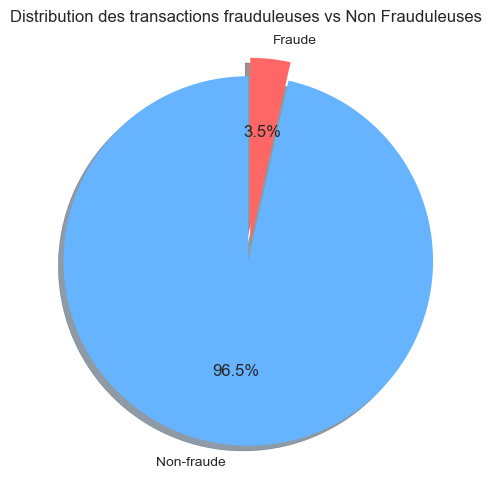

In [18]:
labels = ['Non-fraude', 'Fraude']
# Créer le diagramme circulaire
plt.figure(figsize=(6, 6))
plt.pie(occ, labels=labels, autopct='%1.1f%%', startangle=90, colors = ['#66b3ff', '#ff6666'], explode=(0, 0.1), shadow=True)
plt.title('Distribution des transactions frauduleuses vs Non Frauduleuses ')
plt.show()


3,5 % des transactions sont frauduleuses.
Notre jeu de données initial est très déséquilibré !
La majorité des transactions ne sont pas frauduleuses.

### 2. Analyse des variables explicatives 

In [19]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float16(354), float32(45), int16(1), int32(2), int8(1), object(31)
memory usage: 646.0+ MB


Nous avons des variables de type catégorielle et de type numérique

#### 2.1 Detection et gestion de valeurs manquantes 

<Axes: >

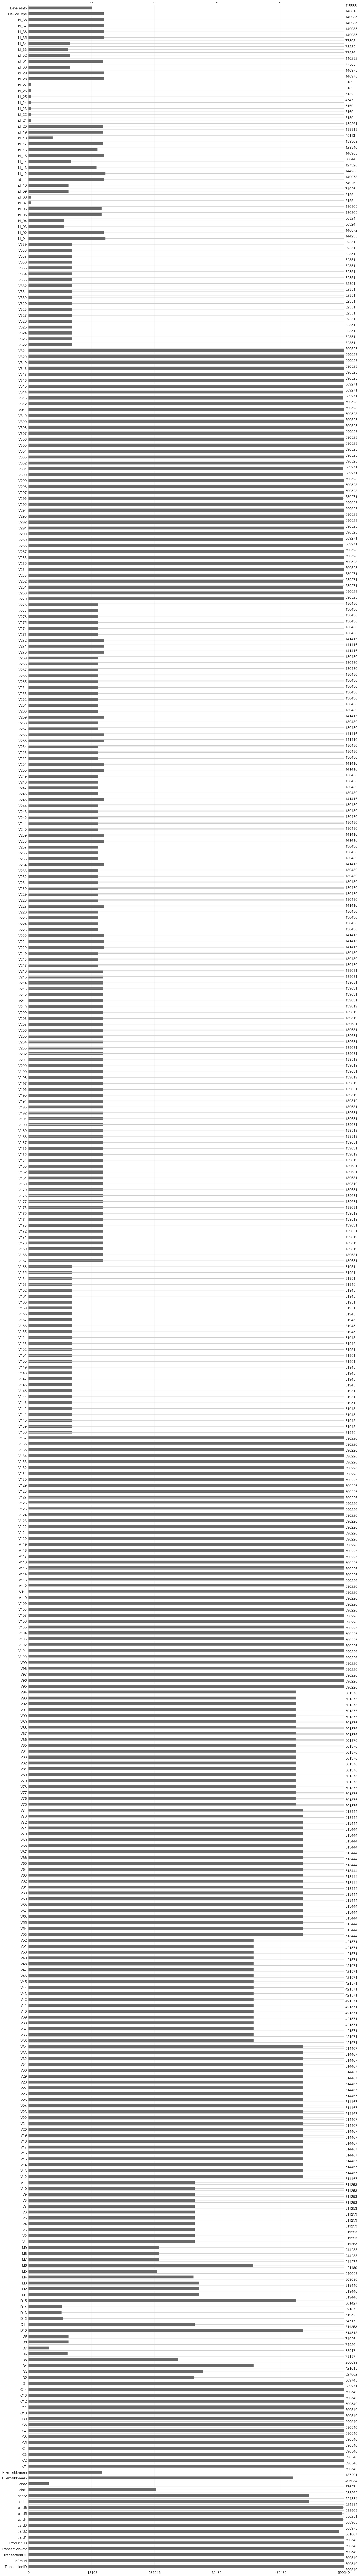

In [20]:
msno.bar(train1)

In [21]:
data_null = train1.isnull().sum() / len(train1) * 100
data_null = data_null.drop(data_null[data_null == 0].index).sort_values(ascending=False)
print(data_null.head())

id_24    99.196159
id_25    99.130965
id_07    99.127070
id_08    99.127070
id_21    99.126393
dtype: float64


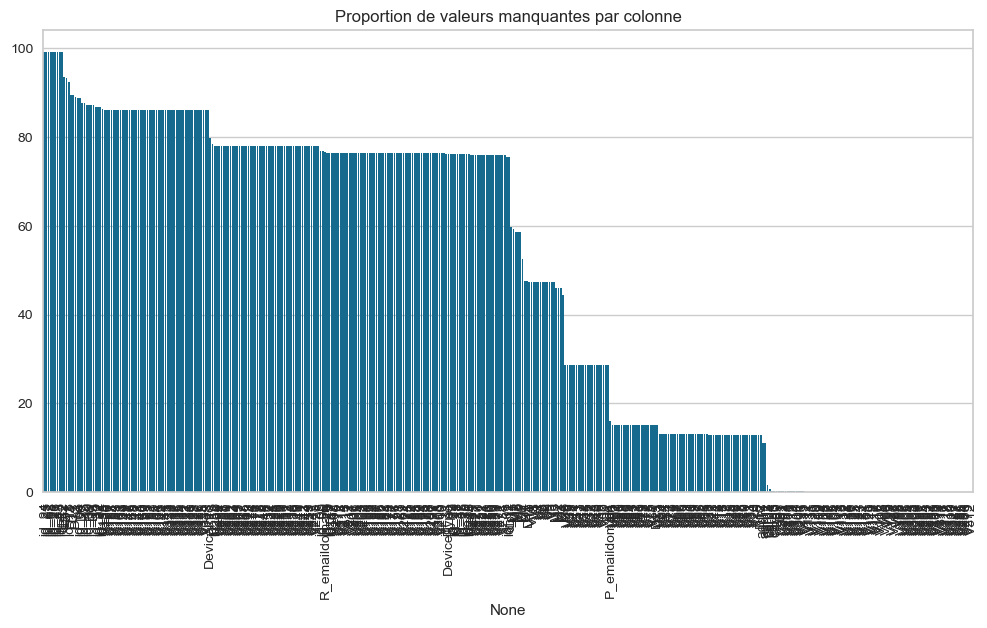

In [22]:
plt.figure(figsize=(12, 6))
sns.barplot(x=data_null.index, y=data_null.values)
plt.xticks(rotation=90)
plt.title("Proportion de valeurs manquantes par colonne")
plt.show()

Certaines colonnes de notre dataset ont plus de 99% de valeurs manquantes; ces dernières ne nous apportent pas beaucoup d'informations et peuvent être supprimées. De manière générale nous allons procéder à la suppression des colonnes contenant plus de 90% de NA car effectuer une imputation risque de biaiser la classification. 

#### 2.2 Suppression des valeurs variables avec un pourcentage élévé de valeurs manquantes

In [23]:
# Seuils
seuil_id = 0.90
seuil_autres = 0.80

# Calcul du taux de valeurs manquantes
na_ratio = train1.isnull().sum() / len(train1)

# Colonnes commençant par "id_"
id_cols = [col for col in train1.columns if col.startswith("id_")]
other_cols = [col for col in train1.columns if col not in id_cols]

# Sélection des colonnes à supprimer selon les seuils
many_null_id_cols = [col for col in id_cols if na_ratio[col] > seuil_id]
many_null_other_cols = [col for col in other_cols if na_ratio[col] > seuil_autres]

# Fusion
many_null_cols = many_null_id_cols + many_null_other_cols

# Affichage
print(f"{len(many_null_cols)} colonnes ont dépassé les seuils de valeurs manquantes.")
print(f"{len(many_null_id_cols)} colonnes 'id_' dépassent {seuil_id*100}% de NA.")
print(f"{len(many_null_other_cols)} autres colonnes dépassent {seuil_autres*100}% de NA.")


65 colonnes ont dépassé les seuils de valeurs manquantes.
10 colonnes 'id_' dépassent 90.0% de NA.
55 autres colonnes dépassent 80.0% de NA.


In [24]:
quasi_const_cols = []
seuil_const = 0.95

for col in train1.columns:
    if col == 'isFraud':
        continue
    top_freq = train1[col].value_counts(normalize=True, dropna=False).values[0]
    if top_freq >= seuil_const:
        quasi_const_cols.append(col)

print(f"{len(quasi_const_cols)} colonnes quasi-constantes détectées.")


38 colonnes quasi-constantes détectées.


In [25]:
one_value_cols = [col for col in train1.columns if train1[col].nunique() == 1]
print(f"{len(one_value_cols)} colonnes avec une seule modalité.")

0 colonnes avec une seule modalité.


Nous adoptons une première stratégie de traitement des valeurs manquantes qui consiste à supprimer les variables ayant une seule modalité, plus de 85% de valeurs manquantes ou une modalité trop dominante (>95 %). Ces variables apportent peu ou pas d'information pertinente au modèle. Leur retrait permet d'améliorer la qualité, la lisibilité et la performance de l’analyse. Pour cela nous allons visualiser 

In [26]:
# Séparer les colonnes "id_" et les autres
id_cols = [col for col in train1.columns if col.startswith("id_")]
other_cols = [col for col in train1.columns if col not in id_cols]

# Colonnes avec une seule modalité
one_value_cols = [col for col in train1.columns if train1[col].nunique() == 1]

# Colonnes avec trop de valeurs manquantes selon le seuil adapté
na_ratio = train1.isnull().sum() / len(train1)
many_null_id_cols = [col for col in id_cols if na_ratio[col] > 0.90]
many_null_other_cols = [col for col in other_cols if na_ratio[col] > 0.80]

# Colonnes dont la modalité principale domine trop
big_top_value_cols = [col for col in train1.columns 
                      if train1[col].value_counts(dropna=False, normalize=True).values[0] > 0.90]

# Fusion de toutes les colonnes à supprimer
cols_to_drop = list(set(one_value_cols + many_null_id_cols + many_null_other_cols + big_top_value_cols))

# Ne jamais supprimer la variable cible
if 'isFraud' in cols_to_drop:
    cols_to_drop.remove('isFraud')

# Suppression dans le train uniquement
train1 = train1.drop(columns=cols_to_drop)

# Résumé
print(f"{len(cols_to_drop)} colonnes supprimées du train car jugées non informatives.")



119 colonnes supprimées du train car jugées non informatives.


In [27]:
print(train1.shape)


(590540, 315)


Par la suite nous allons analyser les variables groupe par groupe ou une à une en faisant un traitement des valeurs manquantes si possible, une création de nouvelles features 

### 2.3 Analyse des variables catégorielles

Nous commençons par définir des fonctions qui nous faciliteront les descriptions et visualisations des variables 

#### Fonction de visualisation et de description 

In [28]:
# Visualisation : cette fonction permet de donner la distribution d'une variable ainsi le taux de fraude pour chaque modalité
def labels(ax, df, xytext=(0, 0)):
    for bar in ax.patches: 
        ax.annotate('%{:.2f}\n{:.0f}'.format(100*bar.get_height()/len(df), bar.get_height()), 
                    (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                    ha='center', va='center', 
                    size=11, xytext=xytext, 
                    textcoords='offset points')

def plot_col(col, df, figsize=(20,6)):
    colors_fraud = ['#1f77b4', 'yellow']  # Bleu pour non fraude, orange pour fraude
    point_color = '#2ca02c'  # Vert pour le pointplot

    fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=True)

    plt.subplot(121)
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    ax[0] = sns.countplot(x=col, data=df, hue='isFraud', 
                         order=np.sort(df[col].dropna().unique()),
                         palette=colors_fraud)
    ax[0].tick_params(axis='x', rotation=90)
    labels(ax[0], df[col].dropna(), (0, 0))

    ax_twin = ax[0].twinx()
    ax_twin = sns.pointplot(x=col, y='Fraud', data=tmp, color=point_color, legend=False, 
                           order=np.sort(df[col].dropna().unique()), linewidth=0.1)

    ax[0].grid()

    plt.subplot(122)
    ax[1] = sns.countplot(x=df[col].dropna(),
                         order=np.sort(df[col].dropna().unique()),
                         color='darkgreen')  # gris pour le second plot
    ax[1].tick_params(axis='x', rotation=90)
    labels(ax[1], df[col].dropna())

    plt.show()


In [29]:
# Description : cette fonction donne pour une variable , ses différentes modalités, ses valeurs manquantes 
def desc_col(expr, df):
    # Filtrer les colonnes qui correspondent à l'expression régulière
    columns = [col for col in df.columns if re.search(expr, col)]

    print('Description des colonnes :\nfeature: dtype, valeurs uniques, taux de valeurs manquantes (%)\n')

    for col in columns:
        dtype = df[col].dtype
        nunique = df[col].nunique()
        null_rate = round(df[col].isna().mean() * 100, 2)
        uniques = pd.Series(df[col].unique()).sort_values().values

        print(f'{col}: {dtype}, {nunique} valeurs uniques, {null_rate}% de valeurs manquantes')
        print(f'Valeurs uniques : {uniques}\n')


**Liste des variables catégorielles**

In [30]:
categorical_vars = train1.select_dtypes(include="object").columns
categorical_vars

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35',
       'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo'],
      dtype='object')

In [31]:
train1[categorical_vars].head(5)

ProductCD       card4   card6 P_emaildomain R_emaildomain   M1   M2   M3  \
0         W    discover  credit           NaN           NaN    T    T    T   
1         W  mastercard  credit     gmail.com           NaN  NaN  NaN  NaN   
2         W        visa   debit   outlook.com           NaN    T    T    T   
3         W  mastercard   debit     yahoo.com           NaN  NaN  NaN  NaN   
4         H  mastercard  credit     gmail.com           NaN  NaN  NaN  NaN   

    M4   M5   M6   M7   M8   M9     id_12 id_15     id_16 id_28     id_29  \
0   M2    F    T  NaN  NaN  NaN       NaN   NaN       NaN   NaN       NaN   
1   M0    T    T  NaN  NaN  NaN       NaN   NaN       NaN   NaN       NaN   
2   M0    F    F    F    F    F       NaN   NaN       NaN   NaN       NaN   
3   M0    T    F  NaN  NaN  NaN       NaN   NaN       NaN   NaN       NaN   
4  NaN  NaN  NaN  NaN  NaN  NaN  NotFound   New  NotFound   New  NotFound   

         id_30                id_31      id_33           id_34 id_35 id_36  \
0          NaN                  NaN        NaN             NaN   NaN   NaN   
1          NaN                  NaN        NaN             NaN   NaN   NaN   
2          NaN                  NaN        NaN             NaN   NaN   NaN   
3          NaN                  NaN        NaN             NaN   NaN   NaN   
4  Android 7.0  samsung browser 6.2  2220x1080  match_status:2     T     F   

  id_37 id_38 DeviceType                     DeviceInfo  
0   NaN   NaN        NaN                            NaN  
1   NaN   NaN        NaN                            NaN  
2   NaN   NaN        NaN                            NaN  
3   NaN   NaN        NaN                            NaN  
4     T     T     mobile  SAMSUNG SM-G892A Build/NRD90M

**Aperçu des valeurs manquantes des variables catégorielles**

Taux de valeurs manquantes :
id_33            0.875895
id_30            0.868654
id_34            0.868248
DeviceInfo       0.799055
id_16            0.780980
R_emaildomain    0.767516
id_31            0.762451
DeviceType       0.761557
id_29            0.761273
id_28            0.761273
id_15            0.761261
id_38            0.761261
id_37            0.761261
id_36            0.761261
id_35            0.761261
id_12            0.755761
M5               0.593494
M7               0.586353
M9               0.586331
M8               0.586331
M4               0.476588
M3               0.459071
M2               0.459071
M1               0.459071
M6               0.286788
P_emaildomain    0.159949
card4            0.002670
card6            0.002660
ProductCD        0.000000
dtype: float64

=== Analyse de la variable : ProductCD ===
Valeurs uniques et fréquences :
ProductCD
W    439670
C     68519
R     37699
H     33024
S     11628
Name: count, dtype: int64

Taux de fraude par modalité :

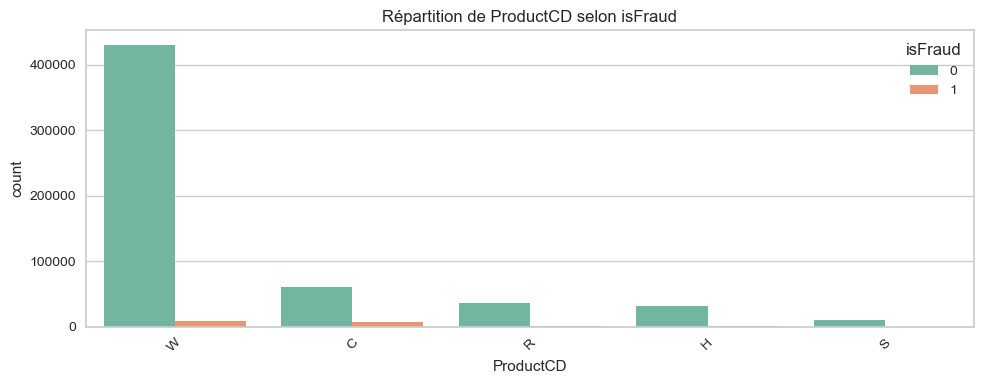


=== Analyse de la variable : card4 ===
Valeurs uniques et fréquences :
card4
visa                384767
mastercard          189217
american express      8328
discover              6651
NaN                   1577
Name: count, dtype: int64

Taux de fraude par modalité :
card4
discover            0.077282
visa                0.034756
mastercard          0.034331
american express    0.028698
Name: isFraud, dtype: float64


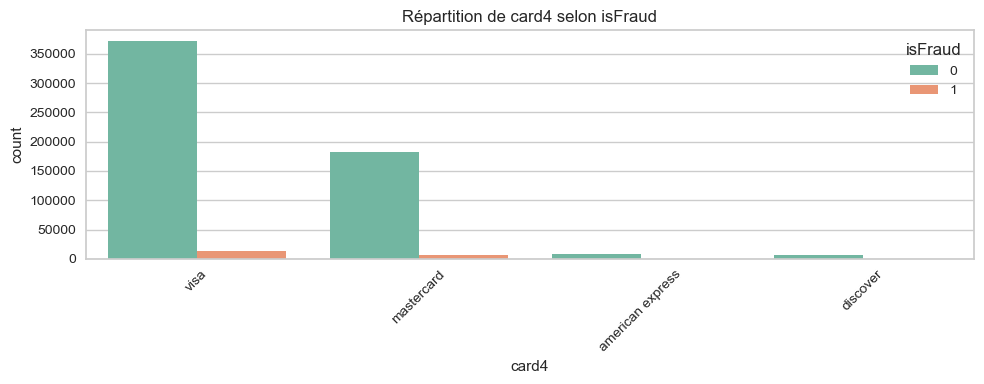


=== Analyse de la variable : card6 ===
Valeurs uniques et fréquences :
card6
debit              439938
credit             148986
NaN                  1571
debit or credit        30
charge card            15
Name: count, dtype: int64

Taux de fraude par modalité :
card6
credit             0.066785
debit              0.024263
charge card        0.000000
debit or credit    0.000000
Name: isFraud, dtype: float64


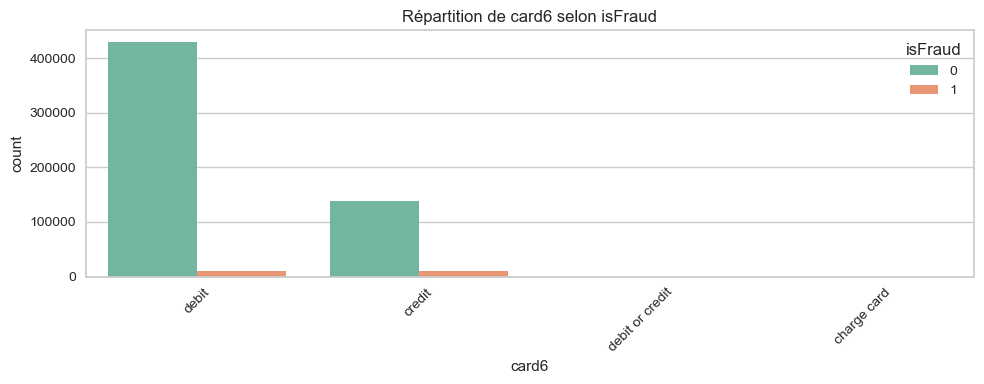


=== Analyse de la variable : P_emaildomain ===
Valeurs uniques et fréquences :
P_emaildomain
gmail.com        228355
yahoo.com        100934
NaN               94456
hotmail.com       45250
anonymous.com     36998
aol.com           28289
comcast.net        7888
icloud.com         6267
outlook.com        5096
msn.com            4092
Name: count, dtype: int64

Taux de fraude par modalité :
P_emaildomain
protonmail.com    0.407895
mail.com          0.189624
outlook.es        0.130137
aim.com           0.126984
outlook.com       0.094584
hotmail.es        0.065574
live.com.mx       0.054740
hotmail.com       0.052950
gmail.com         0.043542
yahoo.fr          0.034965
Name: isFraud, dtype: float64


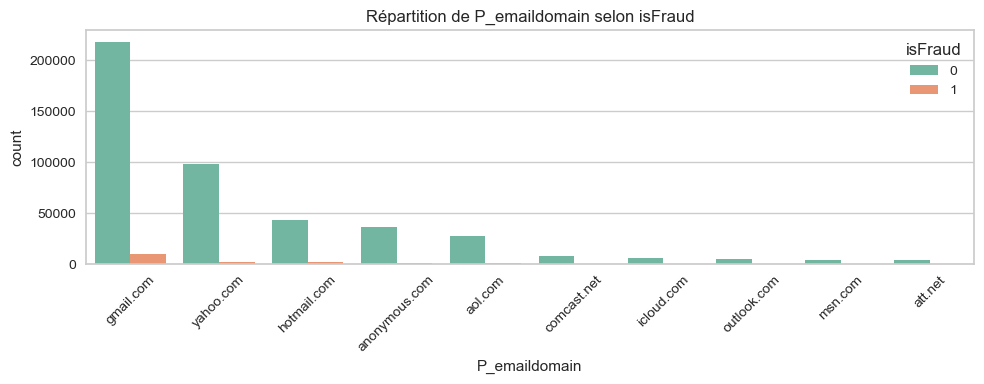


=== Analyse de la variable : R_emaildomain ===
Valeurs uniques et fréquences :
R_emaildomain
NaN              453249
gmail.com         57147
hotmail.com       27509
anonymous.com     20529
yahoo.com         11842
aol.com            3701
outlook.com        2507
comcast.net        1812
yahoo.com.mx       1508
icloud.com         1398
Name: count, dtype: int64

Taux de fraude par modalité :
R_emaildomain
protonmail.com    0.951220
mail.com          0.377049
netzero.net       0.222222
outlook.com       0.165138
outlook.es        0.131640
icloud.com        0.128755
gmail.com         0.119184
hotmail.com       0.077793
earthlink.net     0.075949
hotmail.es        0.068493
Name: isFraud, dtype: float64


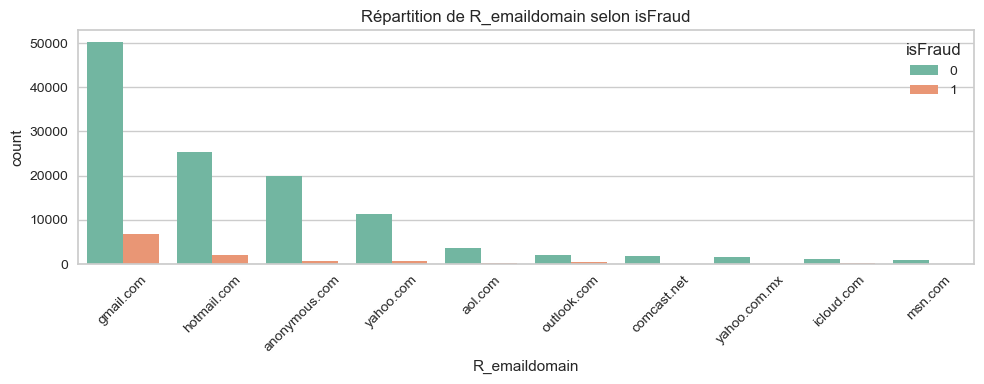


=== Analyse de la variable : M1 ===
Valeurs uniques et fréquences :
M1
T      319415
NaN    271100
F          25
Name: count, dtype: int64

Taux de fraude par modalité :
M1
T    0.019855
F    0.000000
Name: isFraud, dtype: float64


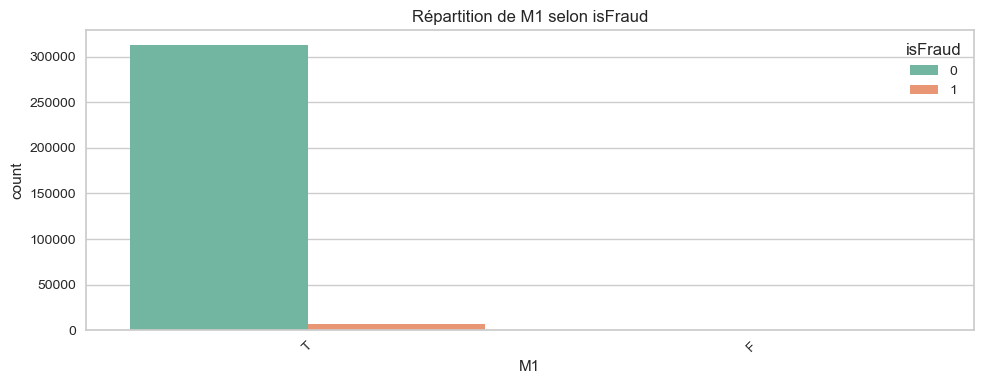


=== Analyse de la variable : M2 ===
Valeurs uniques et fréquences :
M2
T      285468
NaN    271100
F       33972
Name: count, dtype: int64

Taux de fraude par modalité :
M2
F    0.034852
T    0.018069
Name: isFraud, dtype: float64


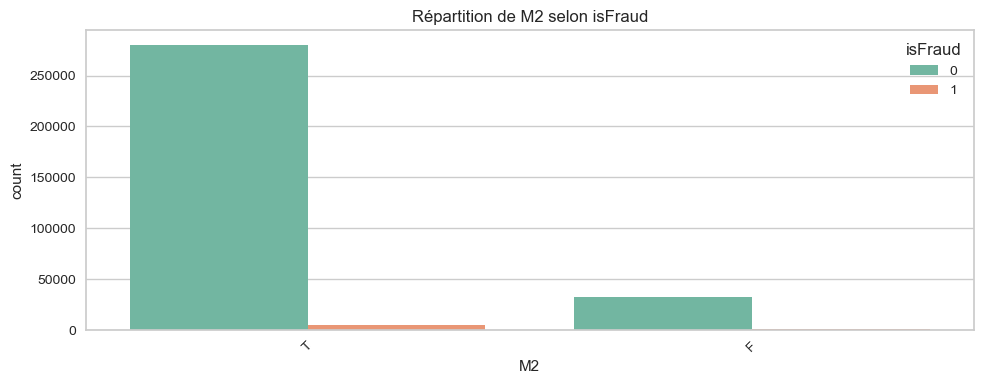


=== Analyse de la variable : M3 ===
Valeurs uniques et fréquences :
M3
NaN    271100
T      251731
F       67709
Name: count, dtype: int64

Taux de fraude par modalité :
M3
F    0.030262
T    0.017054
Name: isFraud, dtype: float64


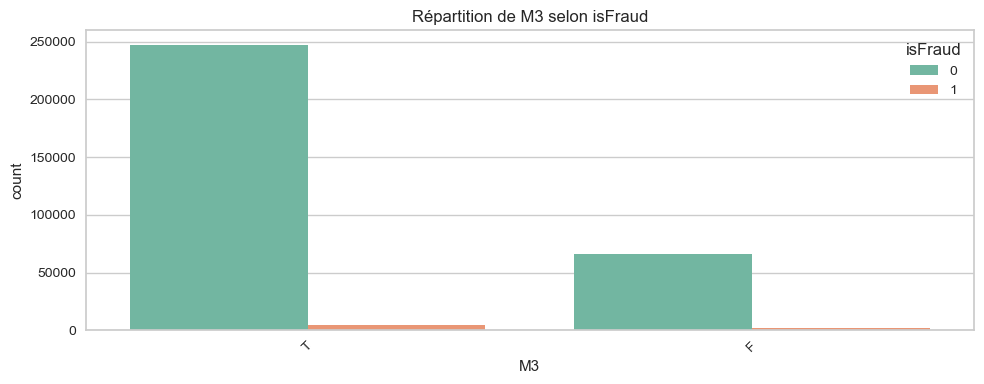


=== Analyse de la variable : M4 ===
Valeurs uniques et fréquences :
M4
NaN    281444
M0     196405
M2      59865
M1      52826
Name: count, dtype: int64

Taux de fraude par modalité :
M4
M2    0.113739
M0    0.036649
M1    0.027051
Name: isFraud, dtype: float64


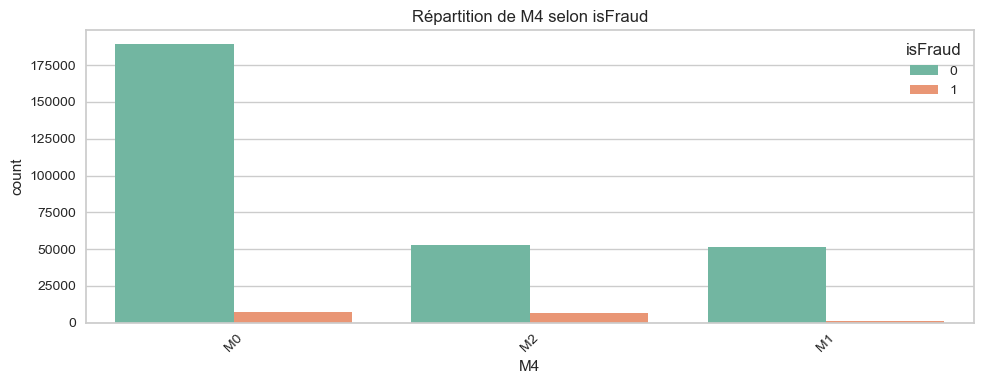


=== Analyse de la variable : M5 ===
Valeurs uniques et fréquences :
M5
NaN    350482
F      132491
T      107567
Name: count, dtype: int64

Taux de fraude par modalité :
M5
T    0.037697
F    0.026523
Name: isFraud, dtype: float64


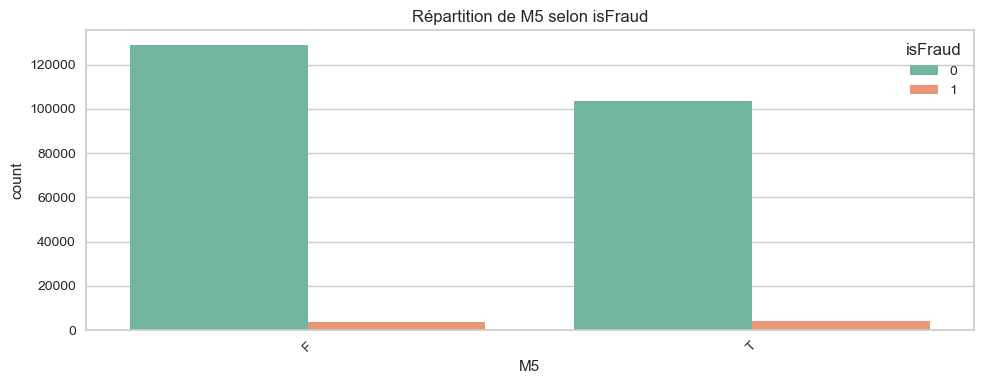


=== Analyse de la variable : M6 ===
Valeurs uniques et fréquences :
M6
F      227856
T      193324
NaN    169360
Name: count, dtype: int64

Taux de fraude par modalité :
M6
F    0.023686
T    0.017044
Name: isFraud, dtype: float64


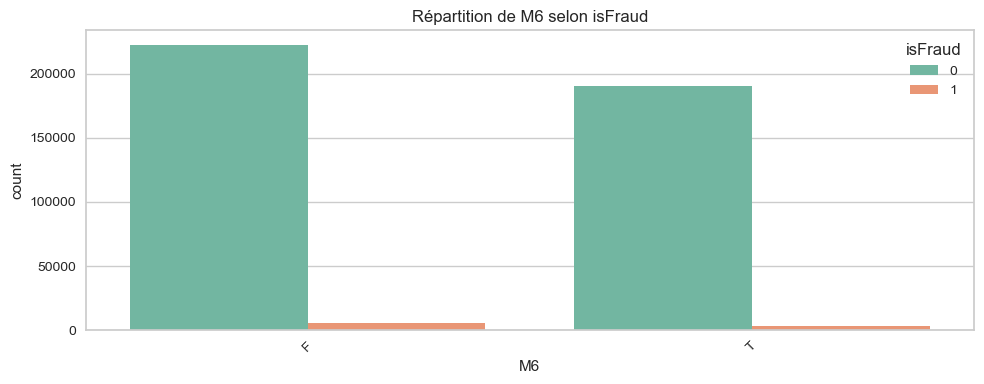


=== Analyse de la variable : M7 ===
Valeurs uniques et fréquences :
M7
NaN    346265
F      211374
T       32901
Name: count, dtype: int64

Taux de fraude par modalité :
M7
T    0.022127
F    0.019345
Name: isFraud, dtype: float64


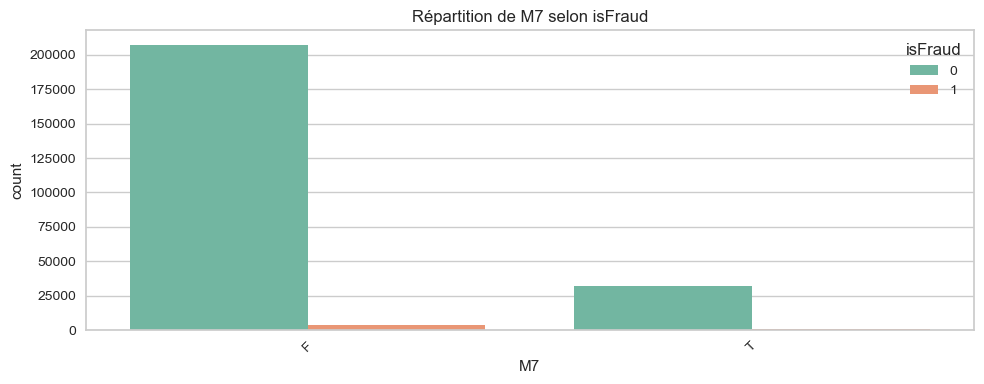


=== Analyse de la variable : M8 ===
Valeurs uniques et fréquences :
M8
NaN    346252
F      155251
T       89037
Name: count, dtype: int64

Taux de fraude par modalité :
M8
F    0.021726
T    0.016218
Name: isFraud, dtype: float64


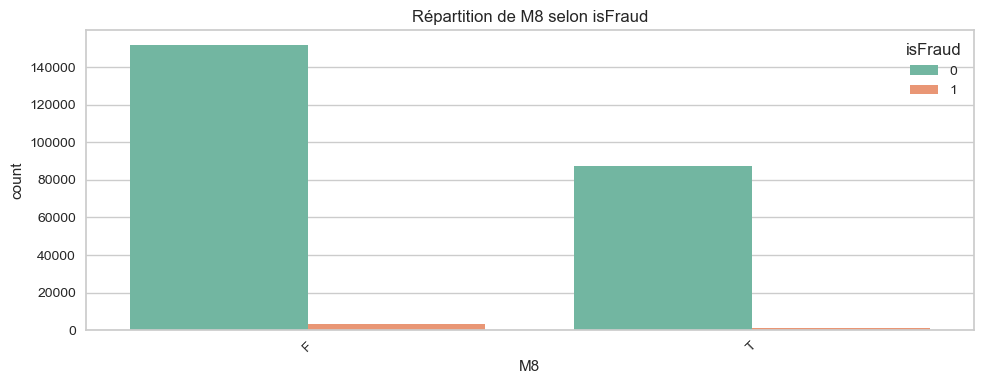


=== Analyse de la variable : M9 ===
Valeurs uniques et fréquences :
M9
NaN    346252
T      205656
F       38632
Name: count, dtype: int64

Taux de fraude par modalité :
M9
F    0.030001
T    0.017787
Name: isFraud, dtype: float64


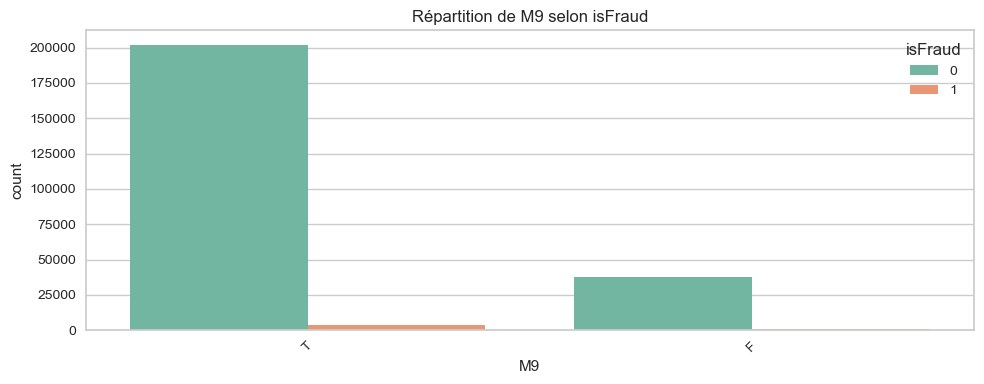


=== Analyse de la variable : id_12 ===
Valeurs uniques et fréquences :
id_12
NaN         446307
NotFound    123025
Found        21208
Name: count, dtype: int64

Taux de fraude par modalité :
id_12
NotFound    0.081683
Found       0.059836
Name: isFraud, dtype: float64


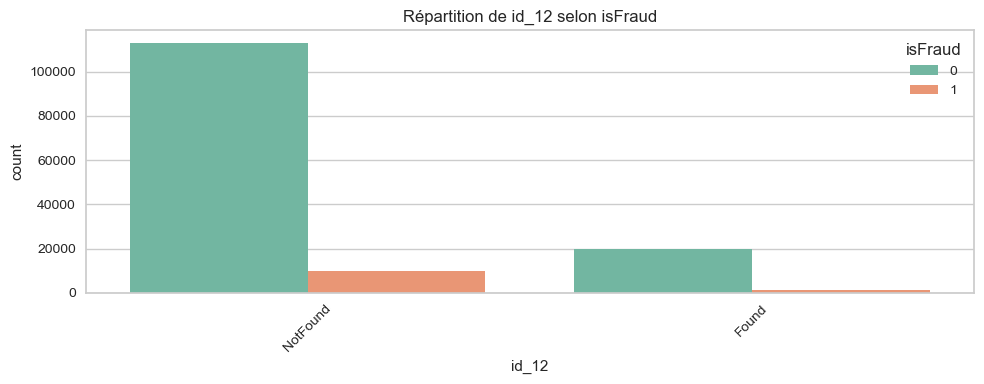


=== Analyse de la variable : id_15 ===
Valeurs uniques et fréquences :
id_15
NaN        449555
Found       67728
New         61612
Unknown     11645
Name: count, dtype: int64

Taux de fraude par modalité :
id_15
Found      0.105097
Unknown    0.091885
New        0.049244
Name: isFraud, dtype: float64


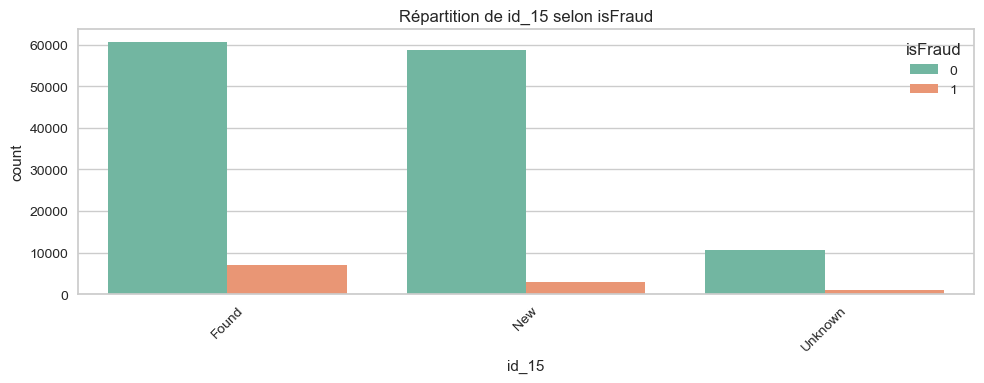


=== Analyse de la variable : id_16 ===
Valeurs uniques et fréquences :
id_16
NaN         461200
Found        66324
NotFound     63016
Name: count, dtype: int64

Taux de fraude par modalité :
id_16
Found       0.107231
NotFound    0.048242
Name: isFraud, dtype: float64


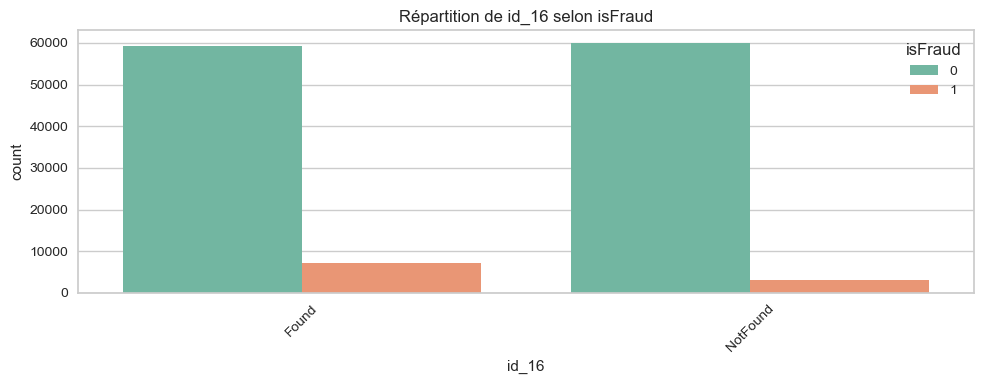


=== Analyse de la variable : id_28 ===
Valeurs uniques et fréquences :
id_28
NaN      449562
Found     76232
New       64746
Name: count, dtype: int64

Taux de fraude par modalité :
id_28
Found    0.102752
New      0.052281
Name: isFraud, dtype: float64


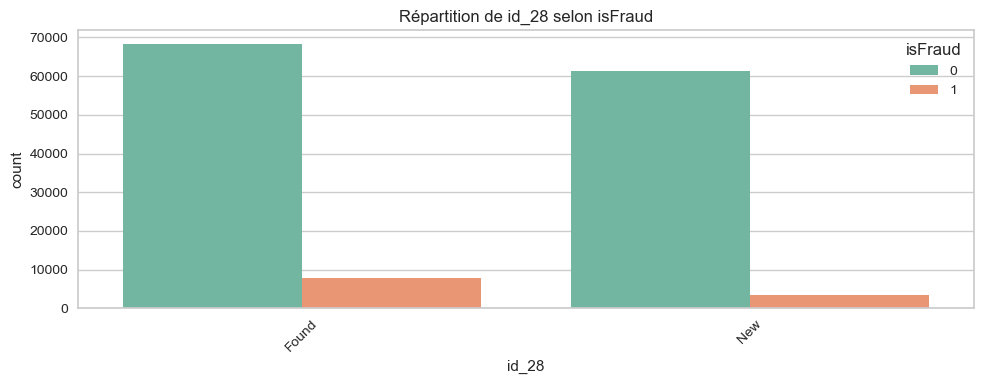


=== Analyse de la variable : id_29 ===
Valeurs uniques et fréquences :
id_29
NaN         449562
Found        74926
NotFound     66052
Name: count, dtype: int64

Taux de fraude par modalité :
id_29
Found       0.104463
NotFound    0.051338
Name: isFraud, dtype: float64


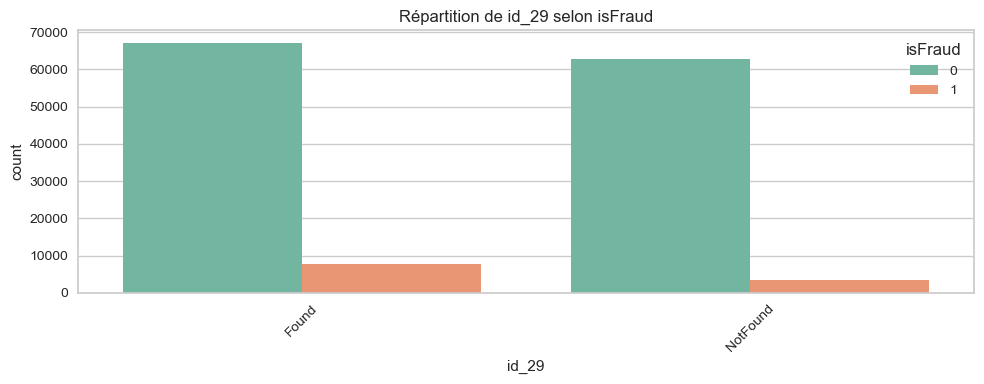


=== Analyse de la variable : id_30 ===
Valeurs uniques et fréquences :
id_30
NaN                 512975
Windows 10           21155
Windows 7            13110
iOS 11.2.1            3722
iOS 11.1.2            3699
Android 7.0           2871
Mac OS X 10_12_6      2559
Mac OS X 10_11_6      2348
iOS 11.3.0            2016
Windows 8.1           1914
Name: count, dtype: int64

Taux de fraude par modalité :
id_30
other            0.600000
Android 5.1.1    0.288571
Android 4.4.2    0.253968
iOS 11.4.0       0.200000
iOS 11.0.1       0.196850
iOS 11.1.0       0.177122
iOS 11.2.5       0.121667
Android 7.1.2    0.121212
iOS 11.2.2       0.117517
Windows 8        0.116667
Name: isFraud, dtype: float64


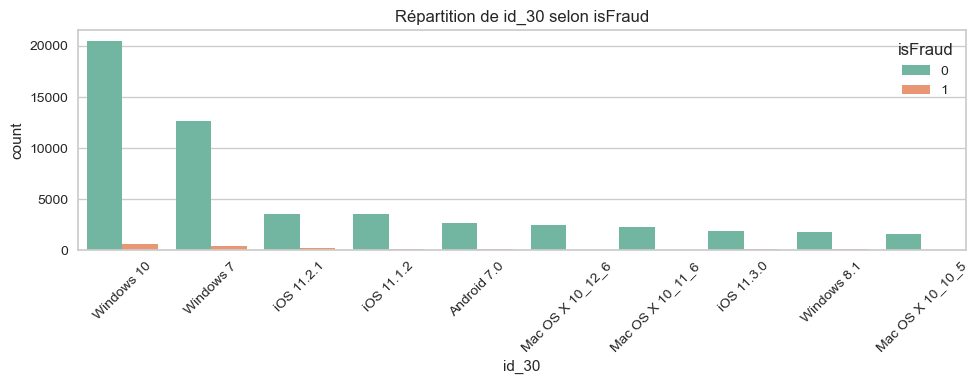


=== Analyse de la variable : id_31 ===
Valeurs uniques et fréquences :
id_31
NaN                        450258
chrome 63.0                 22000
mobile safari 11.0          13423
mobile safari generic       11474
ie 11.0 for desktop          9030
safari generic               8195
chrome 62.0                  7182
chrome 65.0                  6871
chrome 64.0                  6711
chrome 63.0 for android      5806
Name: count, dtype: int64

Taux de fraude par modalité :
id_31
Mozilla/Firefox            1.000000
icedragon                  1.000000
comodo                     0.666667
Lanix/Ilium                0.666667
chrome 49.0 for android    0.547170
opera                      0.481928
opera generic              0.448718
chrome 52.0 for android    0.381579
opera 49.0                 0.311594
samsung browser 5.4        0.302326
Name: isFraud, dtype: float64


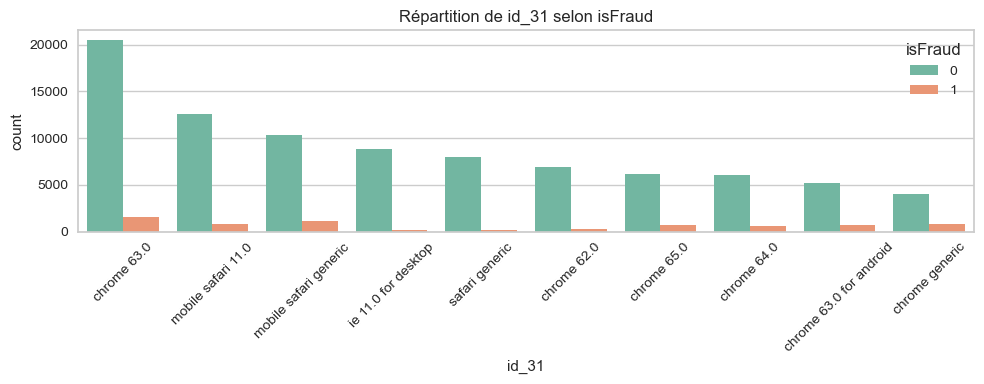


=== Analyse de la variable : id_33 ===
Valeurs uniques et fréquences :
id_33
NaN          517251
1920x1080     16874
1366x768       8605
1334x750       6447
2208x1242      4900
1440x900       4384
1600x900       3510
2048x1536      3482
1280x800       2149
2560x1600      2093
Name: count, dtype: int64

Taux de fraude par modalité :
id_33
1440x759     1.000000
640x360      1.000000
1916x901     1.000000
1024x552     1.000000
2076x1080    1.000000
1920x975     1.000000
1364x768     0.842105
4500x3000    0.666667
1024x600     0.647727
1768x992     0.600000
Name: isFraud, dtype: float64


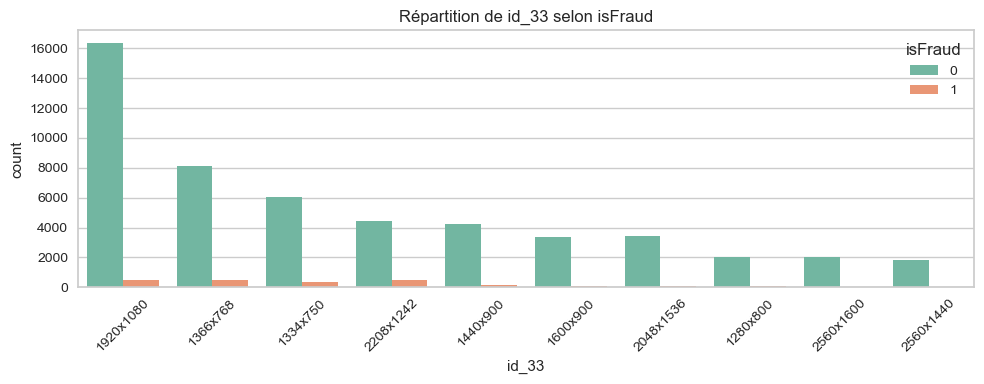


=== Analyse de la variable : id_34 ===
Valeurs uniques et fréquences :
id_34
NaN                512735
match_status:2      60011
match_status:1      17376
match_status:0        415
match_status:-1         3
Name: count, dtype: int64

Taux de fraude par modalité :
id_34
match_status:1     0.063651
match_status:0     0.050602
match_status:2     0.039293
match_status:-1    0.000000
Name: isFraud, dtype: float64


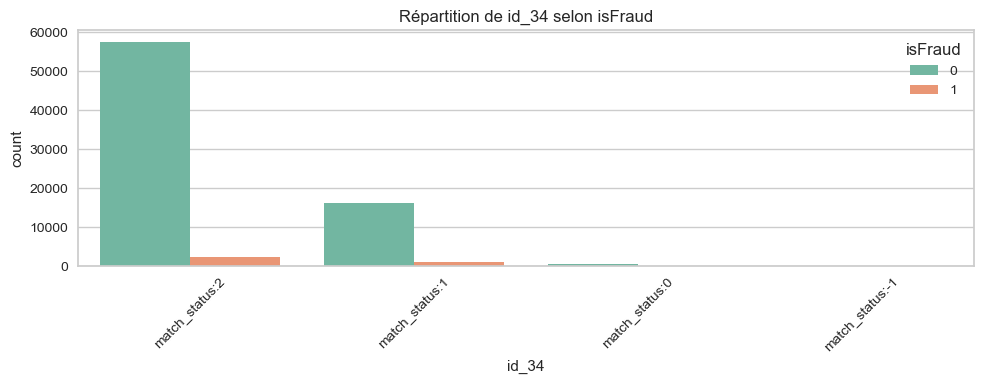


=== Analyse de la variable : id_35 ===
Valeurs uniques et fréquences :
id_35
NaN    449555
T       77814
F       63171
Name: count, dtype: int64

Taux de fraude par modalité :
id_35
F    0.122604
T    0.044683
Name: isFraud, dtype: float64


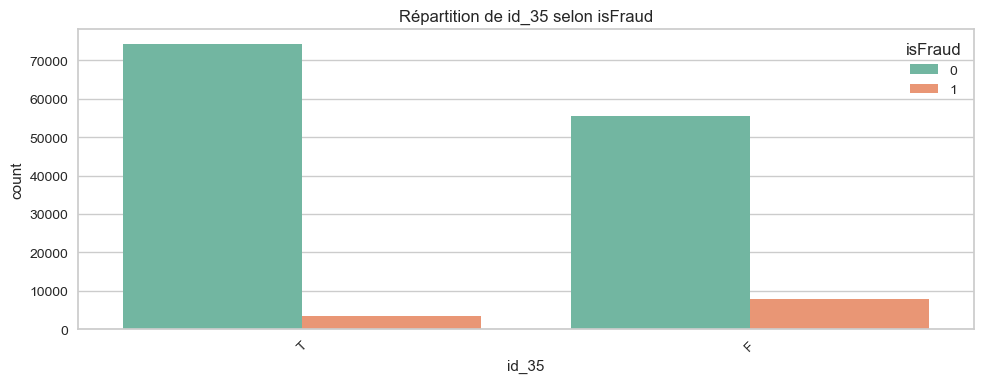


=== Analyse de la variable : id_36 ===
Valeurs uniques et fréquences :
id_36
NaN    449555
F      134066
T        6919
Name: count, dtype: int64

Taux de fraude par modalité :
id_36
F    0.081885
T    0.035265
Name: isFraud, dtype: float64


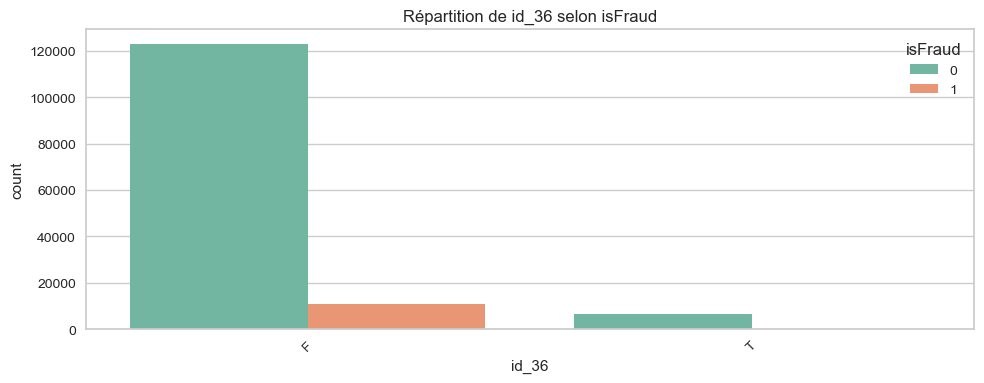


=== Analyse de la variable : id_37 ===
Valeurs uniques et fréquences :
id_37
NaN    449555
T      110452
F       30533
Name: count, dtype: int64

Taux de fraude par modalité :
id_37
T    0.083312
F    0.066158
Name: isFraud, dtype: float64


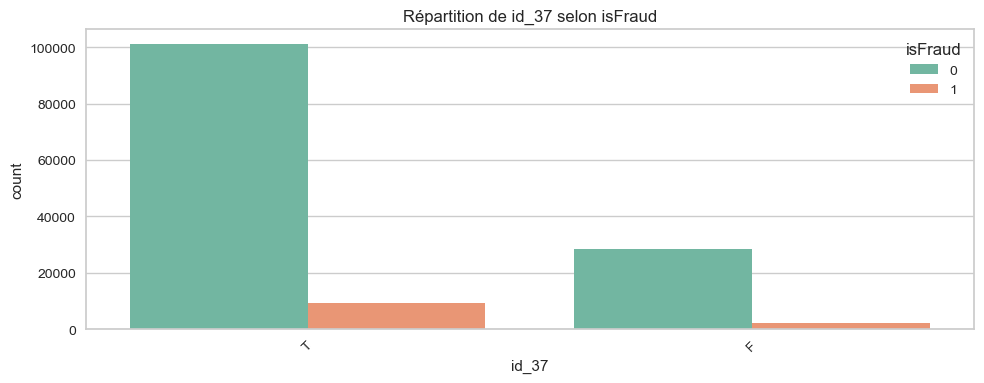


=== Analyse de la variable : id_38 ===
Valeurs uniques et fréquences :
id_38
NaN    449555
F       73922
T       67063
Name: count, dtype: int64

Taux de fraude par modalité :
id_38
F    0.097792
T    0.059541
Name: isFraud, dtype: float64


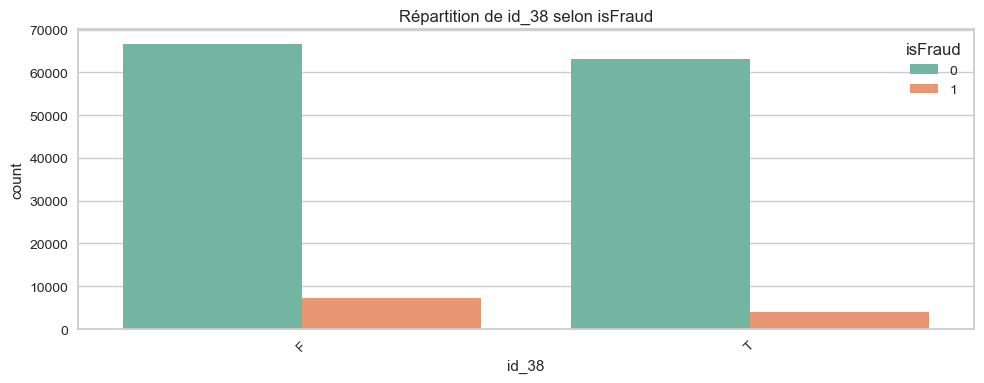


=== Analyse de la variable : DeviceType ===
Valeurs uniques et fréquences :
DeviceType
NaN        449730
desktop     85165
mobile      55645
Name: count, dtype: int64

Taux de fraude par modalité :
DeviceType
mobile     0.101662
desktop    0.065215
Name: isFraud, dtype: float64


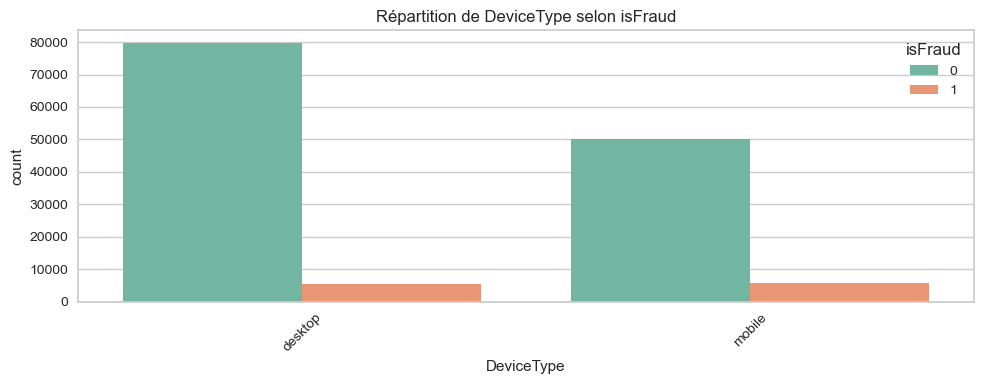


=== Analyse de la variable : DeviceInfo ===
Valeurs uniques et fréquences :
DeviceInfo
NaN                      471874
Windows                   47722
iOS Device                19782
MacOS                     12573
Trident/7.0                7440
rv:11.0                    1901
rv:57.0                     962
SM-J700M Build/MMB29K       549
SM-G610M Build/MMB29K       461
SM-G531H Build/LMY48B       410
Name: count, dtype: int64

Taux de fraude par modalité :
DeviceInfo
ZTE-Z835                       1.0
Dream                          1.0
SM-T285M                       1.0
A5002                          1.0
A466BG                         1.0
SM-T530                        1.0
Blade L3 Build/KOT49H          1.0
RNE-L23 Build/HUAWEIRNE-L23    1.0
SAMSUNG-SM-N900A               1.0
MotoG3-TE Build/MPD24.65-33    1.0
Name: isFraud, dtype: float64


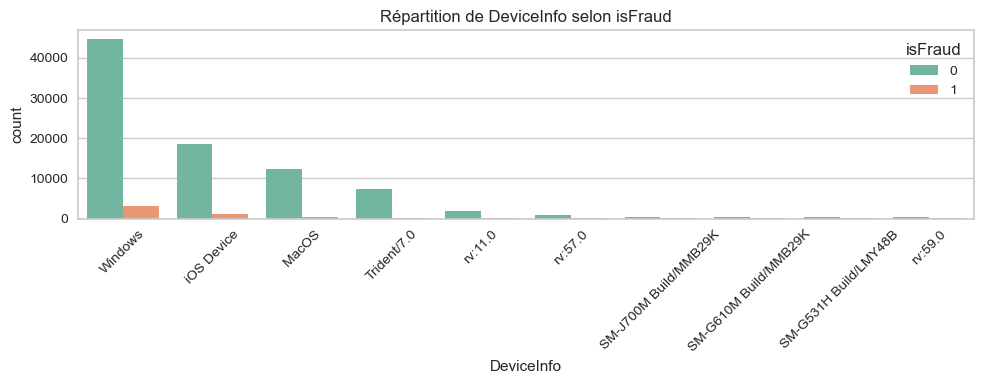

In [32]:
 # Étape 1 : pourcentage de valeurs manquantes
missing_info = train1[categorical_vars].isnull().mean().sort_values(ascending=False)
print("Taux de valeurs manquantes :")
print(missing_info)

# Étape 2 : boucle d'analyse pour chaque variable
for col in categorical_vars:
    print(f"\n=== Analyse de la variable : {col} ===")

    # Top modalités
    print("Valeurs uniques et fréquences :")
    print(train1[col].value_counts(dropna=False).head(10))

    # Taux de fraude par modalité (top 10 seulement pour éviter surcharge visuelle)
    print("\nTaux de fraude par modalité :")
    fraud_rate = train1.groupby(col)['isFraud'].mean().sort_values(ascending=False)
    print(fraud_rate.head(10))
# Graphiques
    plt.figure(figsize=(10, 4))
    sns.countplot(data=train1, x=col, order=train1[col].value_counts().iloc[:10].index,
                  hue='isFraud', palette='Set2')
    plt.title(f"Répartition de {col} selon isFraud")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Nous allons par la suite regarder de plus près ces variables par groupe.

### Variables Devicetype et DeviceInfo

In [33]:
desc_col(expr='Device', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

DeviceType: object, 2 valeurs uniques, 76.16% de valeurs manquantes
Valeurs uniques : ['desktop' 'mobile' nan]

DeviceInfo: object, 1786 valeurs uniques, 79.91% de valeurs manquantes
Valeurs uniques : ['0PAJ5' '0PJA2' '0PM92' ... 'vivo' 'xs-Z47b7VqTMxs' nan]



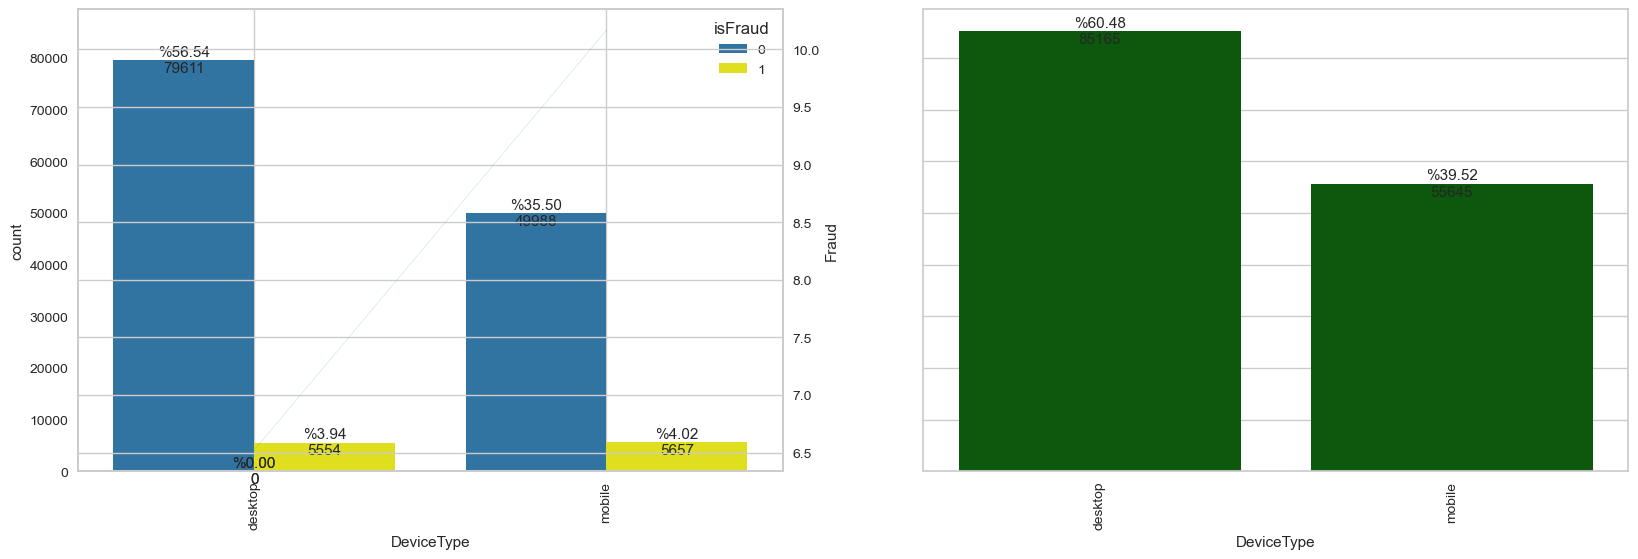

In [34]:
plot_col(col='DeviceType', df=train1)

In [35]:
# Tester si les NA de DeviceInfo et DeviceType creent une différence significative dans le taux de fraude
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# Fonction de test du taux de fraude selon présence ou non de valeurs manquantes
def test_na_fraud_rate(df, col):
    group_na = df[df[col].isnull()]['isFraud']
    group_not_na = df[df[col].notnull()]['isFraud']
    count = np.array([group_na.sum(), group_not_na.sum()])
    nobs = np.array([group_na.count(), group_not_na.count()])
    stat, pval = proportions_ztest(count, nobs)
    return pval

# Application du test sur deux colonnes
test_deviceinfo = test_na_fraud_rate(train1, 'DeviceInfo')
test_devicetype = test_na_fraud_rate(train1, 'DeviceType')
print(f"P-value pour DeviceInfo : {test_deviceinfo:.4f}")
print(f"P-value pour DeviceType : {test_devicetype:.4f}")

P-value pour DeviceInfo : 0.0000
P-value pour DeviceType : 0.0000


In [36]:
# Définir les appareils principaux à conserver
top_devices = ['Windows', 'iOS Device', 'MacOS', 'Trident/7.0']

# Calculer les deux colonnes séparément (sans modifier train1 pour l’instant)
deviceinfo_processed = train1['DeviceInfo'].where(train1['DeviceInfo'].isin(top_devices), 'Other_Device').fillna('Unknown')
devicetype_imputed = train1['DeviceType'].fillna('Unknown')

# Utiliser assign pour ajouter les colonnes en une seule opération (évite la fragmentation)
train1 = train1.assign(
    DeviceInfo_processed=deviceinfo_processed,
    DeviceType_imputed=devicetype_imputed
)


Le test etant significatif, nou gardons les valeurs manquantes et nous imputons les colonnes créées à partir de DeviceType et DeviceInfo par Unknown.

### Variables commençant par 'id'

In [37]:
id_cols = [col for col in train1.columns if col.startswith('id_')]
print(f" {len(id_cols)} colonnes trouvées qui commencent par 'id_':\n")
print(id_cols)

 28 colonnes trouvées qui commencent par 'id_':

['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_19', 'id_20', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


Visualisation des valeurs manquantes (colonnes 'id_'):


<Axes: >

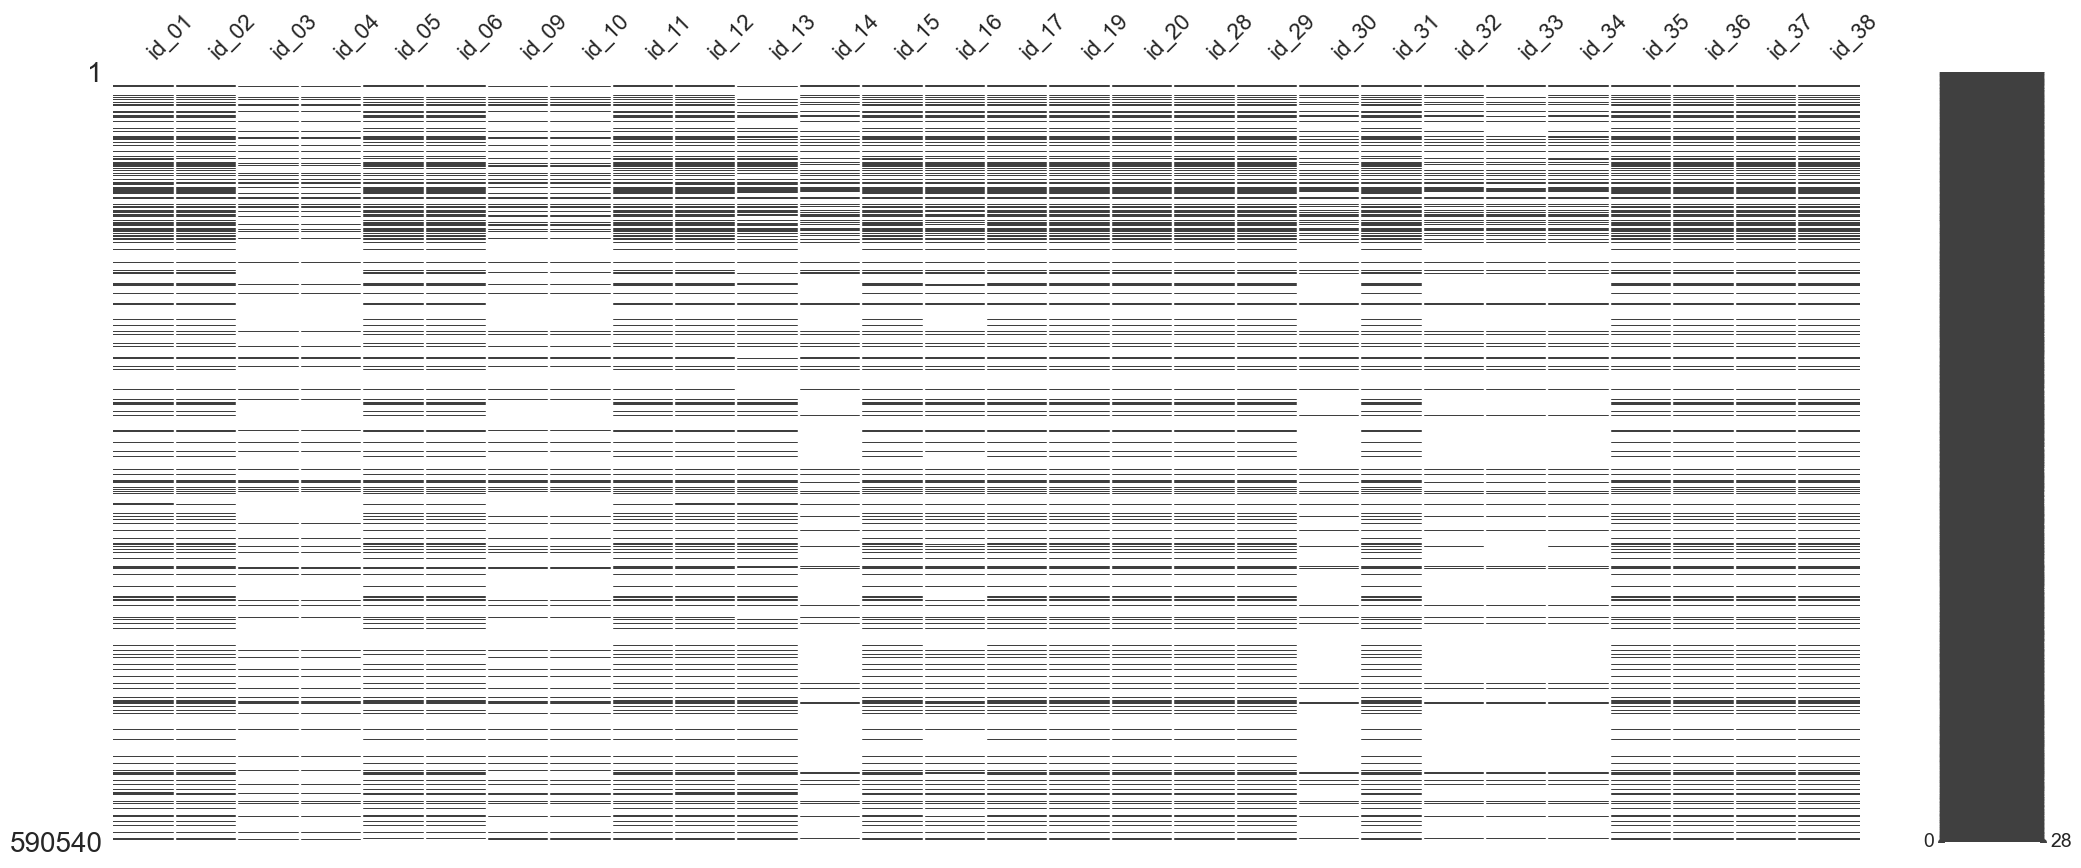

In [38]:
import missingno as msno

print("Visualisation des valeurs manquantes (colonnes 'id_'):")
msno.matrix(train1[id_cols])



On peut voir que certaines variables commençant par id présentent les même distributions de valeurs manquantes. Ces variables sont des identifiants d'identification non explicitement décrites. Nous gardons donc ces valeurs manquantes.

In [39]:
# Imputation des NA par 'undefined' sur les variables id_
id_cat_vars = [col for col in train1.columns if col.startswith("id") and train1[col].dtype in ['object', 'category']]
for col in id_cat_vars:
    train1[col] = train1[col].fillna('undefined')

On commence à détecter les liaisons entre ces variables par le test du khi2 et le V de CRAMER

In [40]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Fonction pour calculer le V de Cramer
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    denom = min((kcorr-1), (rcorr-1))
    if denom == 0:
        return 0.0
    return np.sqrt(phi2corr / denom)

# Fonction pour calculer p-value du chi2 et cramers_v
def chi2_and_cramers_v(var1, var2, df):
    contingency_table = pd.crosstab(df[var1], df[var2])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    cramers = cramers_v(df[var1], df[var2])
    return p, cramers


In [41]:

# 1. Sélection des variables ID catégorielles (dtype 'object' ou 'category')
id_cat_vars = [col for col in train1.columns if col.startswith("id") and train1[col].dtype in ['object', 'category']]

print("Variables id catégorielles :", id_cat_vars)

# 2. Calcul des tests et mesures de liaison pour toutes les paires
results = []
for i, var1 in enumerate(id_cat_vars):
    for var2 in id_cat_vars[i+1:]:
        try:
            p_val, cramers_v_val = chi2_and_cramers_v(var1, var2, train1)
            results.append({'var1': var1, 'var2': var2, 'p_val': p_val, 'cramers_v': cramers_v_val})
        except Exception as e:
            print(f"Erreur sur paire ({var1}, {var2}) : {e}")



Variables id catégorielles : ['id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


In [42]:
# 3. Création du DataFrame résultat
df_results = pd.DataFrame(results)

# 4. Filtrage pour fortes dépendances (par exemple p < 0.05 et cramers_v > 0.7)
strongly_correlated = df_results[(df_results['p_val'] < 0.05) & (df_results['cramers_v'] > 0.7)]

print("Paires fortement corrélées :")
print(strongly_correlated)


Paires fortement corrélées :
     var1   var2  p_val  cramers_v
0   id_12  id_15    0.0   0.727390
2   id_12  id_28    0.0   0.726883
3   id_12  id_29    0.0   0.728228
5   id_12  id_31    0.0   0.708279
8   id_12  id_35    0.0   0.738873
11  id_12  id_38    0.0   0.706213
12  id_15  id_16    0.0   0.989305
13  id_15  id_28    0.0   0.944674
14  id_15  id_29    0.0   0.935139
19  id_15  id_35    0.0   0.735364
20  id_15  id_36    0.0   0.709831
21  id_15  id_37    0.0   0.829753
22  id_15  id_38    0.0   0.710810
23  id_16  id_28    0.0   0.892330
24  id_16  id_29    0.0   0.900134
33  id_28  id_29    0.0   0.990802
35  id_28  id_31    0.0   0.755131
38  id_28  id_35    0.0   0.709464
39  id_28  id_36    0.0   0.708973
40  id_28  id_37    0.0   0.749296
41  id_28  id_38    0.0   0.708962
43  id_29  id_31    0.0   0.753054
46  id_29  id_35    0.0   0.709049
47  id_29  id_36    0.0   0.708751
48  id_29  id_37    0.0   0.747114
49  id_29  id_38    0.0   0.708776
53  id_30  id_35    0.0   

### R_emaildomain et P_email domain

Nous décomposons l’adresse e-mail en deux parties pour les deux variables :

R_emaildomain_1 : le fournisseur principal de l’e-mail (avant le premier point).

R_emaildomain_2 : la suite du domaine (après le premier point, ex. com, co.uk, etc.).

Cela permet d’analyser séparément les différents niveaux du domaine d’e-mail, ce qui peut aider à mieux comprendre certains comportements liés à la fraude.

In [43]:
desc_col(expr='emaildomain', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

P_emaildomain: object, 59 valeurs uniques, 15.99% de valeurs manquantes
Valeurs uniques : ['aim.com' 'anonymous.com' 'aol.com' 'att.net' 'bellsouth.net'
 'cableone.net' 'centurylink.net' 'cfl.rr.com' 'charter.net' 'comcast.net'
 'cox.net' 'earthlink.net' 'embarqmail.com' 'frontier.com'
 'frontiernet.net' 'gmail' 'gmail.com' 'gmx.de' 'hotmail.co.uk'
 'hotmail.com' 'hotmail.de' 'hotmail.es' 'hotmail.fr' 'icloud.com'
 'juno.com' 'live.com' 'live.com.mx' 'live.fr' 'mac.com' 'mail.com'
 'me.com' 'msn.com' 'netzero.com' 'netzero.net' 'optonline.net'
 'outlook.com' 'outlook.es' 'prodigy.net.mx' 'protonmail.com' 'ptd.net'
 'q.com' 'roadrunner.com' 'rocketmail.com' 'sbcglobal.net' 'sc.rr.com'
 'servicios-ta.com' 'suddenlink.net' 'twc.com' 'verizon.net' 'web.de'
 'windstream.net' 'yahoo.co.jp' 'yahoo.co.uk' 'yahoo.com' 'yahoo.com.mx'
 'yahoo.de' 'yahoo.es' 'yahoo.fr' 'ymail.com' nan]

R_emaildomain: objec

In [44]:
# Pour R_emaildomain
train1['R_emaildomain_1'] = train1['R_emaildomain'].fillna('').apply(
    lambda x: x.split('.')[0] if x else np.nan
).replace({'': np.nan})

train1['R_emaildomain_2'] = train1['R_emaildomain'].fillna('').apply(
    lambda x: '.'.join(x.split('.')[1:]).strip('.') if '.' in x else np.nan
).replace({'': np.nan})

# Pour P_emaildomain
train1['P_emaildomain_1'] = train1['P_emaildomain'].fillna('').apply(
    lambda x: x.split('.')[0] if x else np.nan
).replace({'': np.nan})

train1['P_emaildomain_2'] = train1['P_emaildomain'].fillna('').apply(
    lambda x: '.'.join(x.split('.')[1:]).strip('.') if '.' in x else np.nan
).replace({'': np.nan})


In [45]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Exemple : association entre domaines suffixes
v_cramer = cramers_v(train1['R_emaildomain_2'], train1['P_emaildomain_2'])
print("V de Cramér :", round(v_cramer, 3))


V de Cramér : 0.891


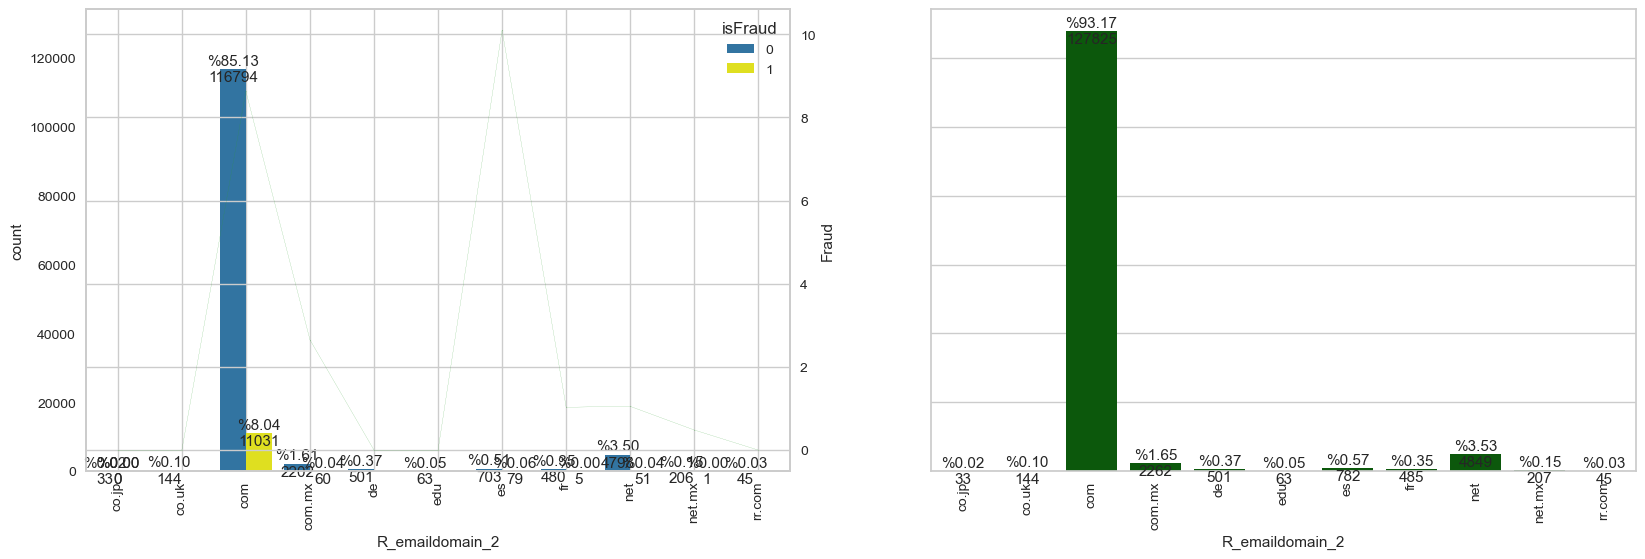

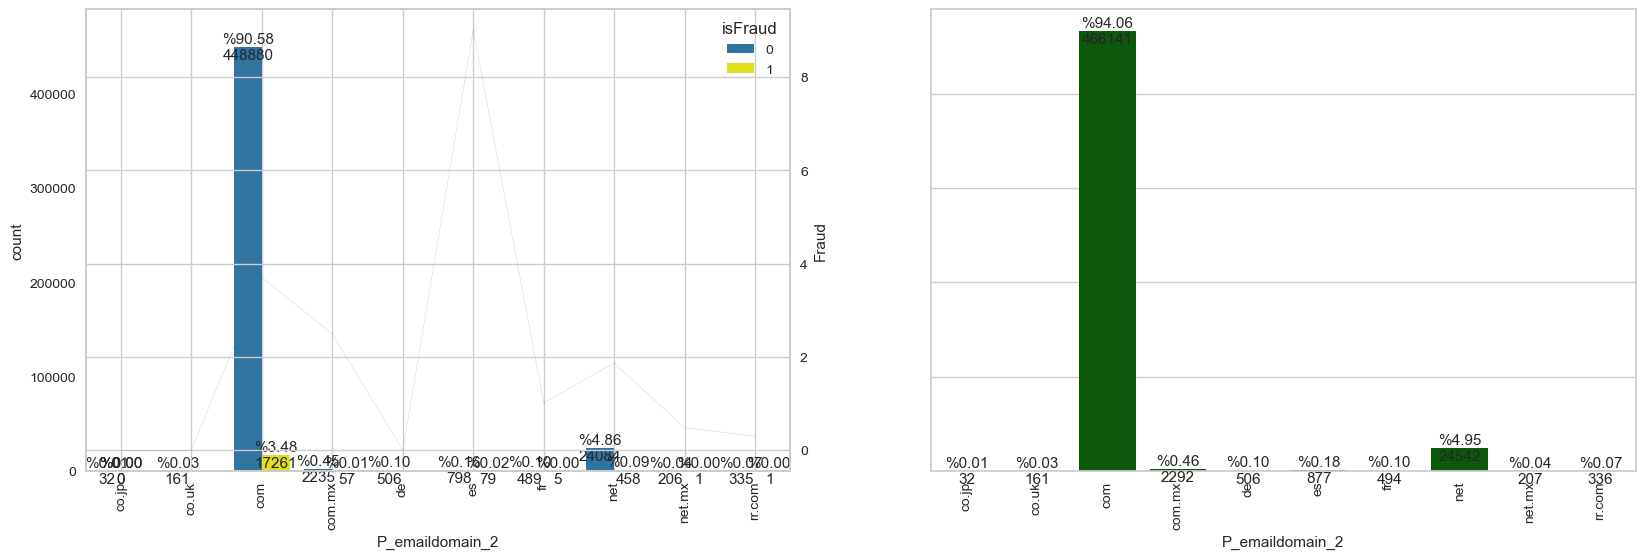

In [46]:
for col in ['R_emaildomain_2', 'P_emaildomain_2']:
  plot_col(col, df=train1)

In [47]:
train1['R_emaildomain_1'] = train1['R_emaildomain_1'].fillna('undefined')
train1['R_emaildomain_2'] = train1['R_emaildomain_2'].fillna('undefined')

In [48]:
train1['P_emaildomain_1'] = train1['P_emaildomain_1'].fillna('undefined')
train1['P_emaildomain_2'] = train1['P_emaildomain_2'].fillna('undefined')

### Variables commençant par M

In [49]:
desc_col(expr='M', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

M1: object, 2 valeurs uniques, 45.91% de valeurs manquantes
Valeurs uniques : ['F' 'T' nan]

M2: object, 2 valeurs uniques, 45.91% de valeurs manquantes
Valeurs uniques : ['F' 'T' nan]

M3: object, 2 valeurs uniques, 45.91% de valeurs manquantes
Valeurs uniques : ['F' 'T' nan]

M4: object, 3 valeurs uniques, 47.66% de valeurs manquantes
Valeurs uniques : ['M0' 'M1' 'M2' nan]

M5: object, 2 valeurs uniques, 59.35% de valeurs manquantes
Valeurs uniques : ['F' 'T' nan]

M6: object, 2 valeurs uniques, 28.68% de valeurs manquantes
Valeurs uniques : ['F' 'T' nan]

M7: object, 2 valeurs uniques, 58.64% de valeurs manquantes
Valeurs uniques : ['F' 'T' nan]

M8: object, 2 valeurs uniques, 58.63% de valeurs manquantes
Valeurs uniques : ['F' 'T' nan]

M9: object, 2 valeurs uniques, 58.63% de valeurs manquantes
Valeurs uniques : ['F' 'T' nan]



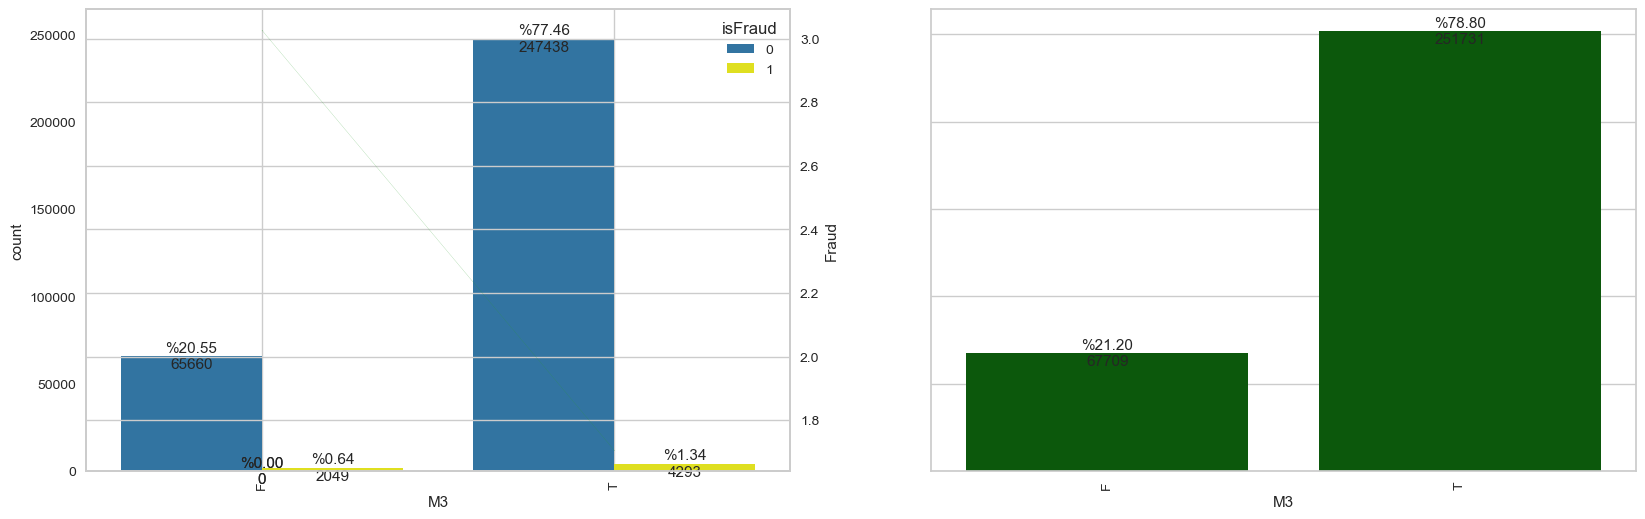

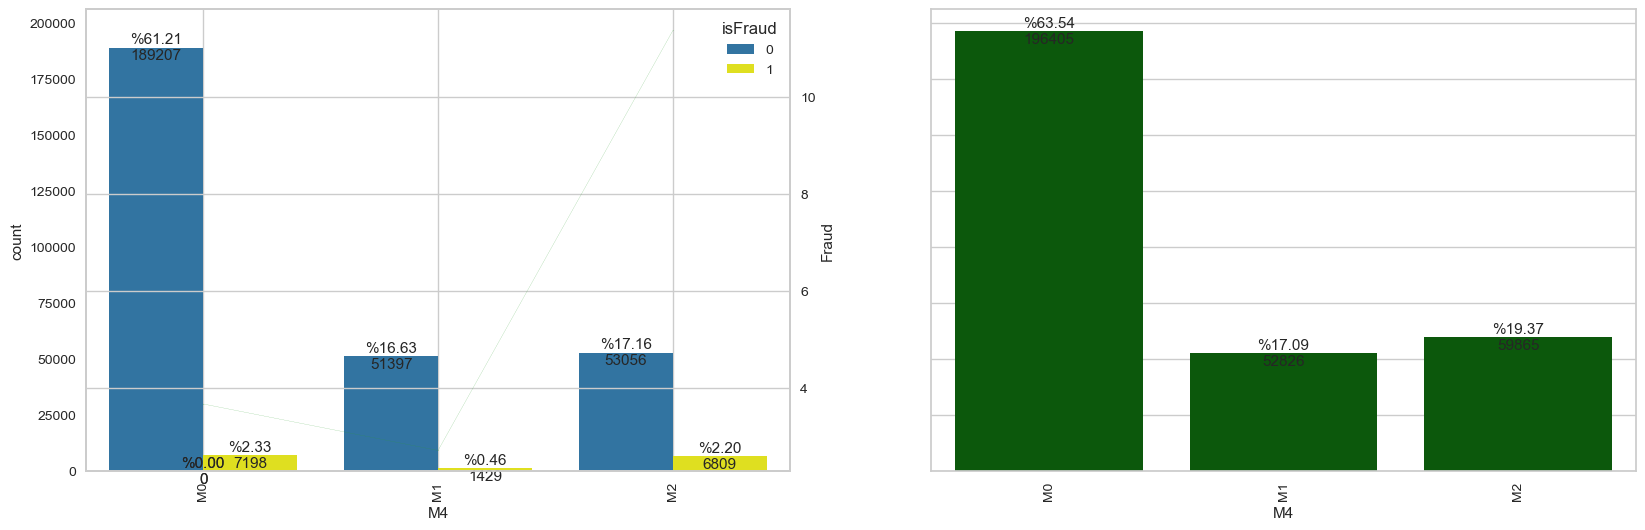

In [50]:
for col in ['M3', 'M4']:
  plot_col(col, df=train1)

In [51]:
# Remplace les NaN par 'undefined' pour les colonnes catégorielles commençant par 'id' ou 'M' suivi d'un chiffre entre 1 et 9
cat_cols = [col for col in train1.columns if col.startswith('id') or re.fullmatch(r'M[1-9]', col)]

# Appliquer uniquement aux colonnes catégorielles
train1[cat_cols] = train1[cat_cols].fillna('undefined')


In [52]:
# Compter les valeurs manquantes parmi M1 à M9 avant remplacement
m_cols = [f'M{i}' for i in range(1, 10)]  # ['M1', 'M2', ..., 'M9']
train1['M_missing_count'] = train1[m_cols].isna().sum(axis=1)


### Product CD, card4 et card6

In [53]:
desc_col(expr='ProductCD', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

ProductCD: object, 5 valeurs uniques, 0.0% de valeurs manquantes
Valeurs uniques : ['C' 'H' 'R' 'S' 'W']



Cette variable ne présente aucune valeur manquante

In [54]:
desc_col(expr='card4', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

card4: object, 4 valeurs uniques, 0.27% de valeurs manquantes
Valeurs uniques : ['american express' 'discover' 'mastercard' 'visa' nan]



In [55]:
desc_col(expr='card6', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

card6: object, 4 valeurs uniques, 0.27% de valeurs manquantes
Valeurs uniques : ['charge card' 'credit' 'debit' 'debit or credit' nan]



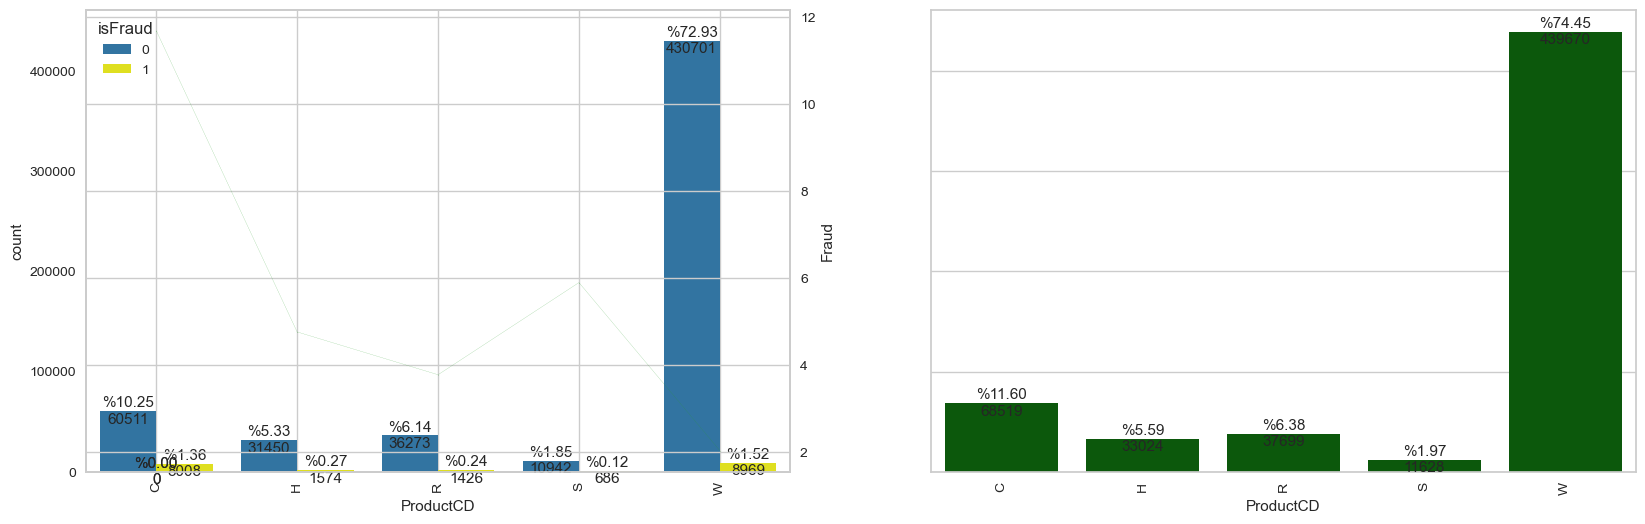

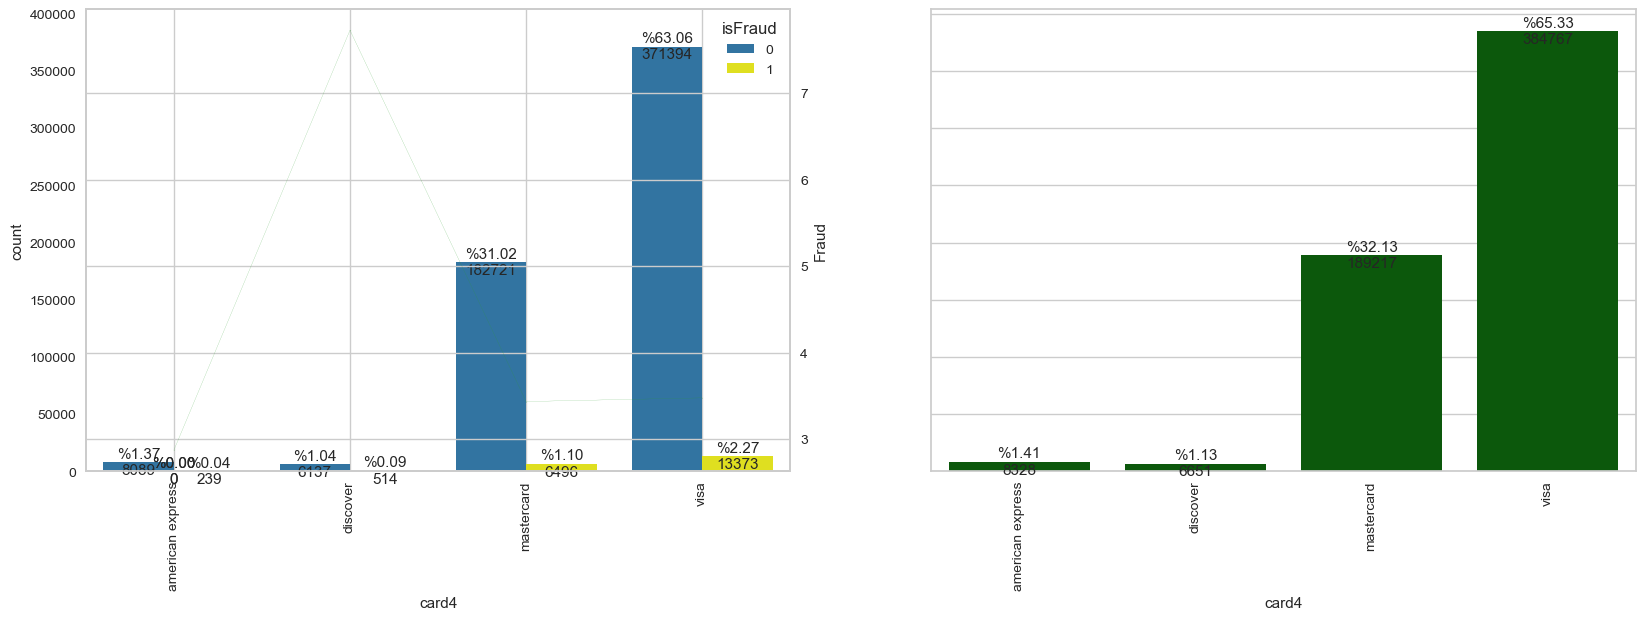

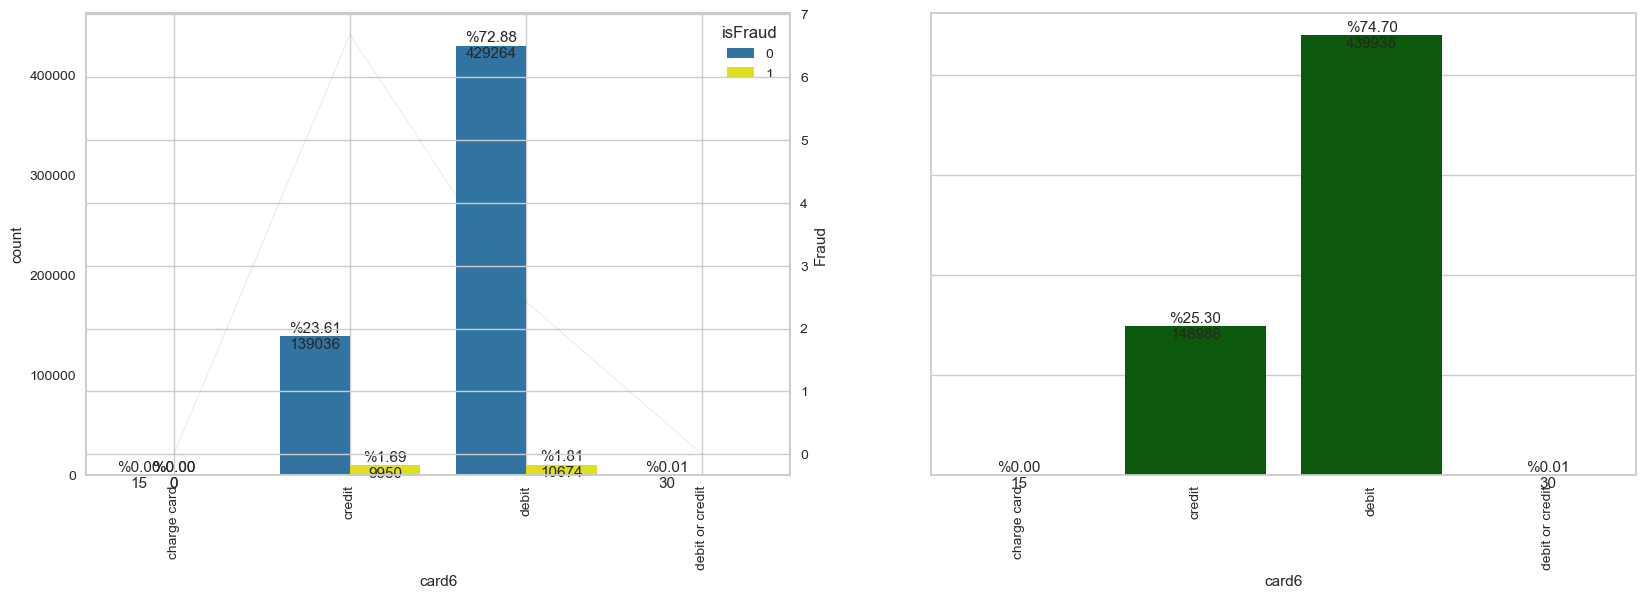

In [56]:
for col in ['ProductCD', 'card4', 'card6']:
  plot_col(col, df=train1)

In [57]:
# Masques booléens des NA
na_card4 = train1['card4'].isna()
na_card6 = train1['card6'].isna()

# Vérifier s'ils sont égaux (ligne par ligne)
same_na_rows = (na_card4 == na_card6)

# Afficher combien de lignes ont les deux NA en même temps
both_na = (na_card4 & na_card6).sum()
print(f"Nombre de lignes où card4 ET card6 sont NA : {both_na}")

# Vérifier si les NA apparaissent exactement aux mêmes lignes
if same_na_rows.all():
    print(" Les lignes avec NA dans card4 sont exactement les mêmes que celles de card6.")
else:
    print(" Les lignes NA dans card4 et card6 ne correspondent pas exactement.")




Nombre de lignes où card4 ET card6 sont NA : 1565
 Les lignes NA dans card4 et card6 ne correspondent pas exactement.


In [58]:
# Imputation par le mode 
for col in ['card4', 'card6']:
    mode_value = train1[col].mode()[0]
    train1[col] = train1[col].fillna(mode_value)


Les % de valeurs manquantes étant faibles, on impute par le mode. 

### Autres variables catégorielles

Les variables suivantes sont catégorielles mais sont codées type en numeriques. 

### Variables commençant par 'card'

In [59]:
desc_col(expr=r'card', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

card1: int16, 13553 valeurs uniques, 0.0% de valeurs manquantes
Valeurs uniques : [ 1000  1001  1004 ... 18393 18395 18396]

card2: float16, 500 valeurs uniques, 1.51% de valeurs manquantes
Valeurs uniques : [100. 101. 102. 103. 104. 105. 106. 108. 109. 110. 111. 112. 113. 114.
 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142.
 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156.
 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170.
 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184.
 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198.
 199. 200. 201. 202. 203. 204. 205. 206. 207. 208. 209. 210. 211. 212.
 213. 214. 215. 216. 217. 218. 219. 220. 221. 222. 223. 224. 225. 226.
 227. 228. 229. 230. 231. 232. 233. 234. 235. 236. 237. 238. 

In [60]:
for col in ['card1', 'card2', 'card3', 'card5']:
    train1[col] = train1[col].fillna(train1[col].mode()[0])

In [61]:
for col in ['card1', 'card2', 'card3', 'card5']:
    train1[col] = train1[col].astype(str).astype('category')

Ces variables ont très peu de valeurs manquantes, on procède par une imputation par le mode. 

### Variables commençant par addr

In [62]:
desc_col(expr=r'addr', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

addr1: float16, 332 valeurs uniques, 11.13% de valeurs manquantes
Valeurs uniques : [100. 101. 102. 104. 105. 106. 110. 111. 112. 113. 117. 119. 120. 122.
 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 137. 139.
 141. 142. 143. 144. 145. 146. 148. 151. 152. 153. 154. 155. 156. 157.
 158. 159. 160. 161. 162. 163. 164. 166. 167. 168. 170. 171. 172. 174.
 177. 178. 180. 181. 182. 183. 184. 185. 187. 189. 190. 191. 193. 194.
 195. 196. 198. 199. 200. 201. 202. 203. 204. 205. 206. 208. 210. 211.
 213. 214. 215. 216. 217. 218. 219. 220. 221. 223. 224. 225. 226. 227.
 231. 232. 233. 234. 235. 236. 237. 238. 239. 241. 242. 243. 244. 245.
 247. 248. 249. 250. 251. 252. 253. 254. 255. 257. 258. 259. 260. 261.
 262. 264. 265. 268. 269. 270. 272. 274. 275. 276. 277. 278. 279. 280.
 282. 283. 284. 286. 290. 292. 294. 295. 296. 297. 298. 299. 300. 301.
 302. 303. 304. 305. 306. 307. 308. 309. 31

Ces variables representant des informations caractéristiques. La transformation des valeurs manquantes pourrait intrduire des biais : Nous imputons par une valeur significative. 

In [63]:
for col in ['addr1', 'addr2']:
    train1[col] = train1[col].fillna('undefined').astype('category')

### Analyse des variables numériques 

In [64]:
numeric_vars = train1.select_dtypes(include='number').columns
numeric_vars

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'dist1',
       'C1', 'C2', 'C4', 'C5', 'C6',
       ...
       'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317',
       'M_missing_count'],
      dtype='object', length=266)

In [65]:
train1[numeric_vars].head(5)

TransactionID  isFraud  TransactionDT  TransactionAmt  dist1   C1   C2  \
0        2987000        0          86400            68.5   19.0  1.0  1.0   
1        2987001        0          86401            29.0    NaN  1.0  1.0   
2        2987002        0          86469            59.0  287.0  1.0  1.0   
3        2987003        0          86499            50.0    NaN  2.0  5.0   
4        2987004        0          86506            50.0    NaN  1.0  1.0   

    C4   C5   C6   C7   C8   C9  C10  C11  C12   C13  C14     D1     D2    D3  \
0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   
1  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   
2  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   
3  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0   
4  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   

     D4   D5   D10    D11    D15   V1   V2   V3   V4   V5   V6   V7   V8   V9  \
0   NaN  NaN  13.0   13.0    0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
1   0.0  NaN   0.0    NaN    0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2   0.0  NaN   0.0  315.0  315.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3  94.0  0.0  84.0    NaN  111.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4   NaN  NaN   NaN    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V10  V11  V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  \
0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0   
1  NaN  NaN  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0   
2  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0   
3  NaN  NaN  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V25  V26  V27  V28  V29  V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  \
0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN   
1  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0   
2  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
3  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V40  V41  V42  V43  V44  V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0   
1  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0   
3  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V55  V56  V57  V58  V59  V60  V61  V62  V63  V64  V65  V66  V67  V68  V69  \
0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
1  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
2  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
3  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V70  V71  V72  V73  V74  V75  V76  V77  V78  V79  V80  V81  V82  V83  V84  \
0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V85  V86  V87  V88  V89  V90  V91  V92  V93  V94  V95   V96   V97   V99  \
0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   1.0   0.0   0.0   
1  0.

### Variables C1-C14 dist1

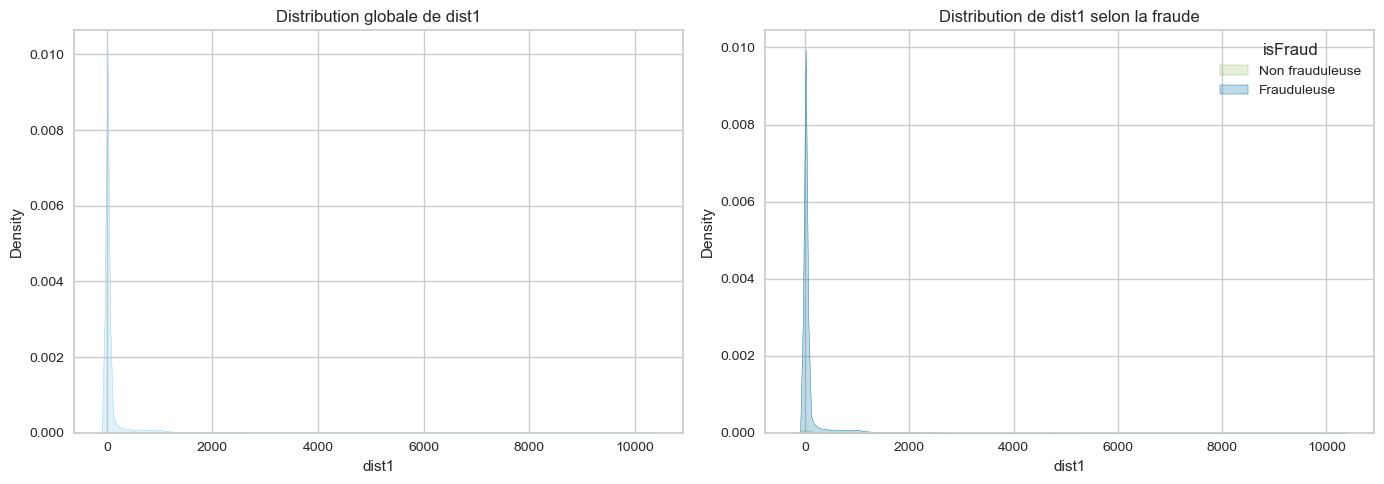

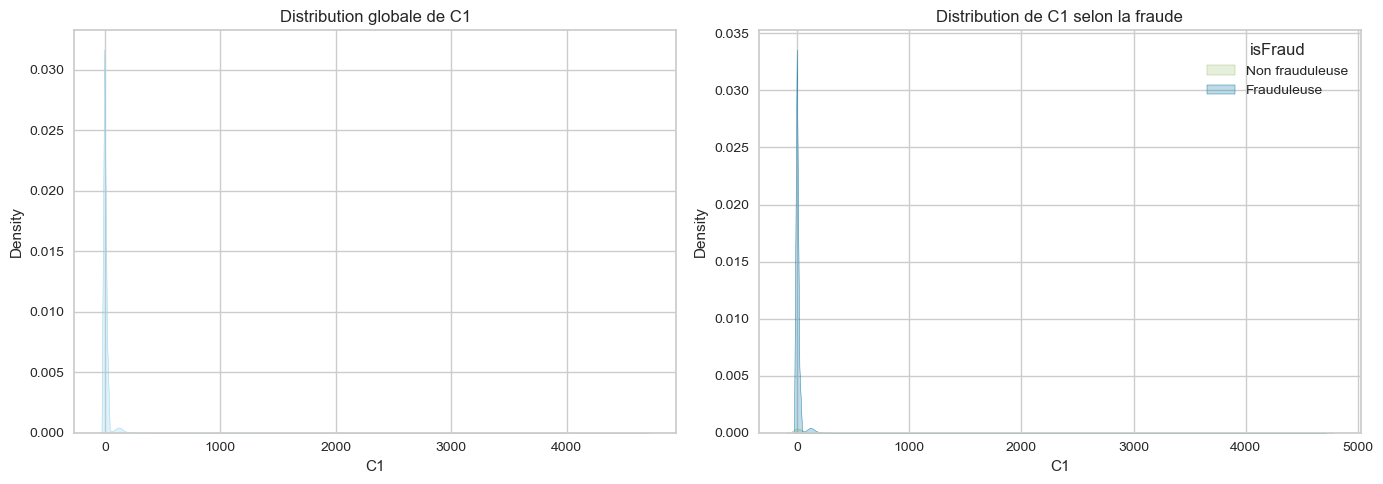

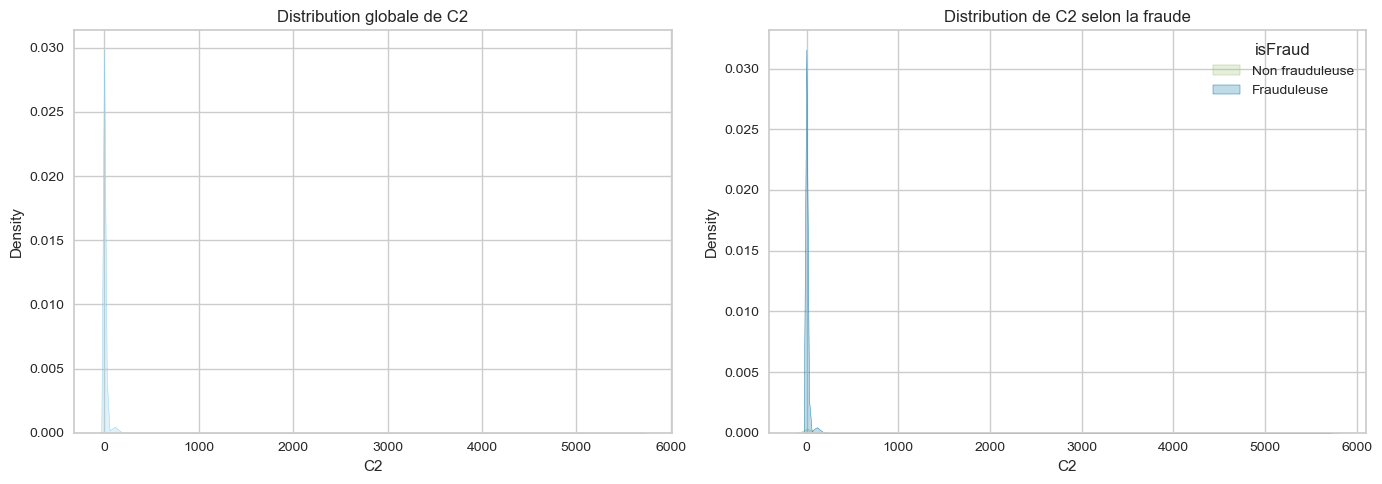

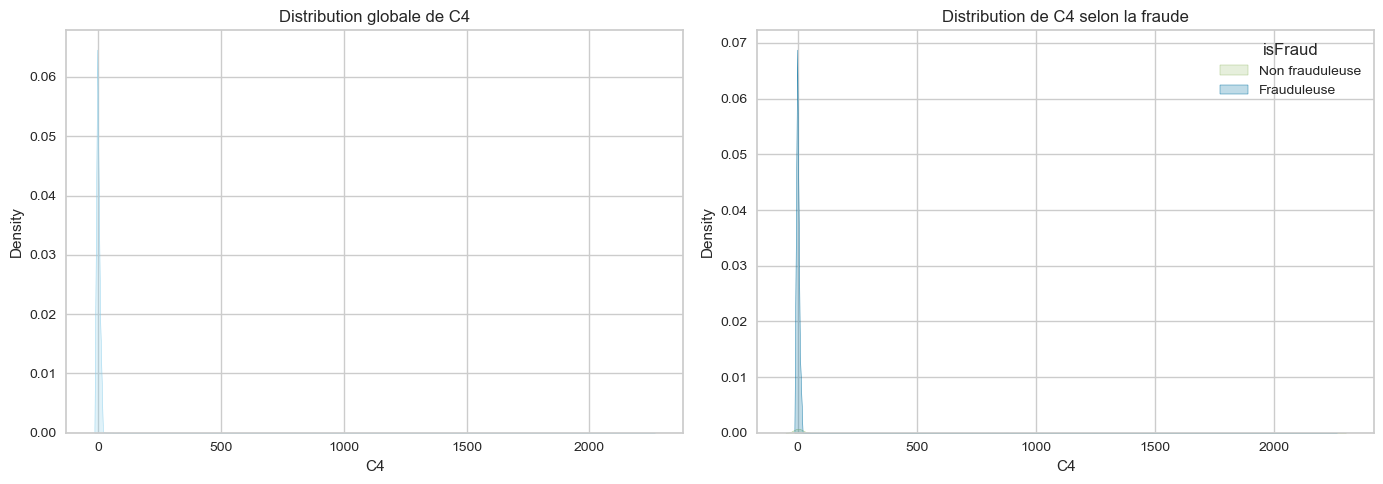

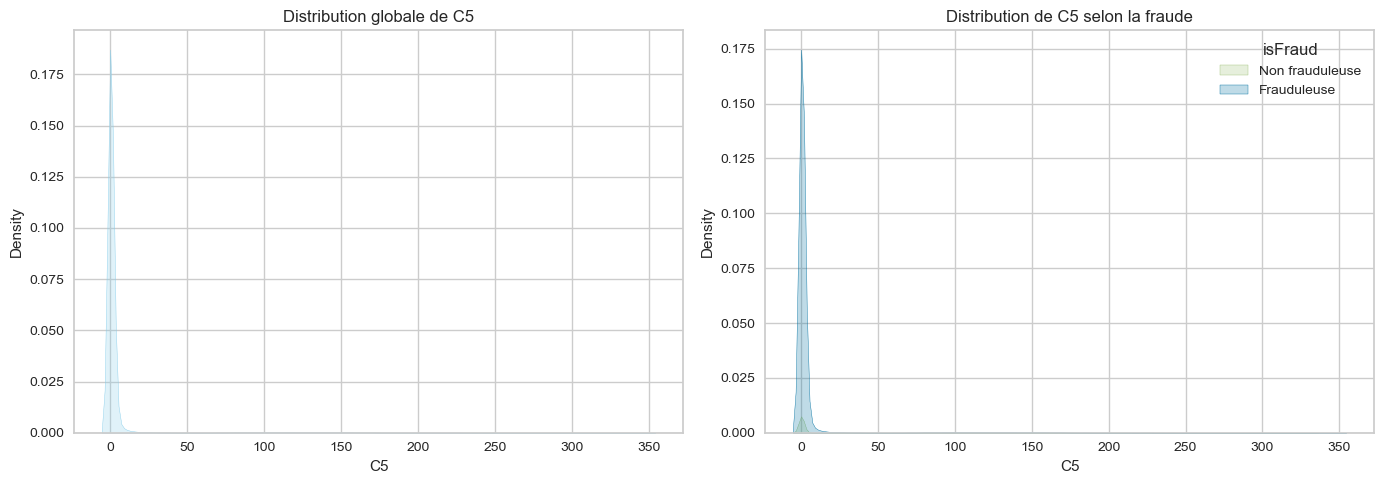

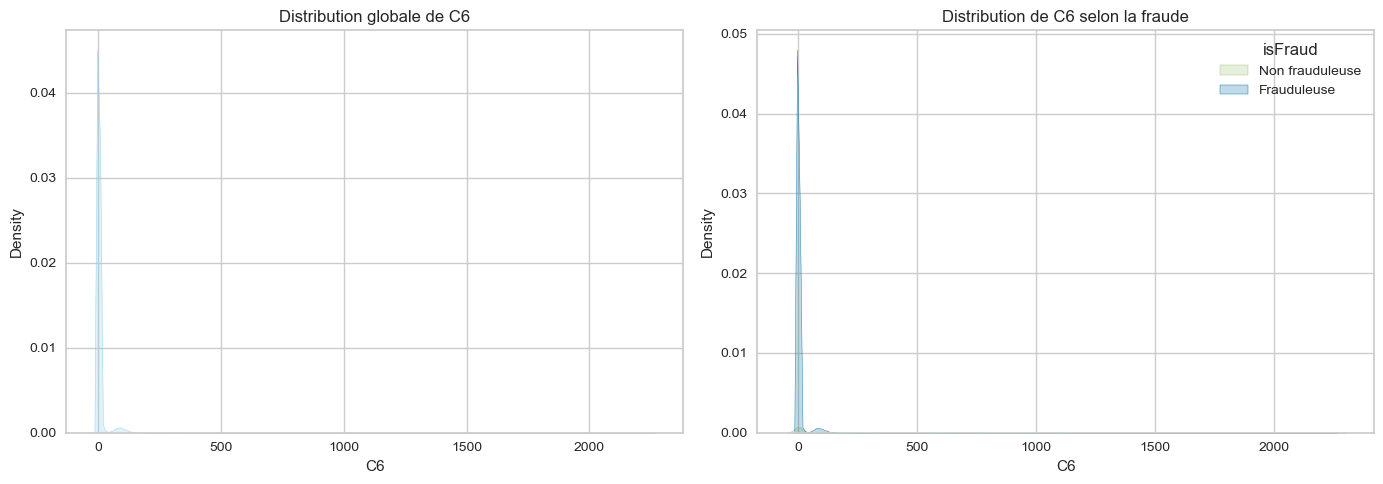

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Liste des variables à visualiser
variables = ['dist1', 'C1', 'C2', 'C4', 'C5', 'C6']

# Boucle sur chaque variable
for var in variables:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Graphique 1 : Distribution globale avec kde
    sns.kdeplot(data=train1, x=var, fill=True, ax=axs[0], color='skyblue')
    axs[0].set_title(f'Distribution globale de {var}')
    axs[0].set_xlabel(var)

    # 2. Graphique 2 : Distribution selon la fraude (isFraud)
    sns.kdeplot(data=train1, x=var, hue='isFraud', fill=True, ax=axs[1])
    axs[1].set_title(f'Distribution de {var} selon la fraude')
    axs[1].set_xlabel(var)
    axs[1].legend(title='isFraud', labels=['Non frauduleuse', 'Frauduleuse'])

    plt.tight_layout()
    plt.show()


La distribution très asymétrique des variables, notamment les C, suggère la présence de valeurs aberrantes. Toutefois, en l'absence d'informations précises sur leur signification, nous avons choisi de ne pas les modifier afin de préserver d'éventuels signaux utiles à la détection de fraude. Par ailleurs, la variable dist1, représentant probablement une distance géographique sera également gardée telle quelle. Cependant nous procederons à une normalisation.

In [67]:
desc_col(expr=r'^C\d', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

C1: float16, 1495 valeurs uniques, 0.0% de valeurs manquantes
Valeurs uniques : [0.000e+00 1.000e+00 2.000e+00 ... 4.672e+03 4.680e+03 4.684e+03]

C2: float16, 1167 valeurs uniques, 0.0% de valeurs manquantes
Valeurs uniques : [0.000e+00 1.000e+00 2.000e+00 ... 5.624e+03 5.688e+03 5.692e+03]

C4: float16, 1223 valeurs uniques, 0.0% de valeurs manquantes
Valeurs uniques : [0.000e+00 1.000e+00 2.000e+00 ... 2.248e+03 2.250e+03 2.252e+03]

C5: float16, 319 valeurs uniques, 0.0% de valeurs manquantes
Valeurs uniques : [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  7

Pas de valeurs manquantes 

### Variables dist1

In [68]:
desc_col(expr='^dist', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

dist1: float16, 2412 valeurs uniques, 59.65% de valeurs manquantes
Valeurs uniques : [0.000e+00 1.000e+00 2.000e+00 ... 8.080e+03 1.029e+04       nan]



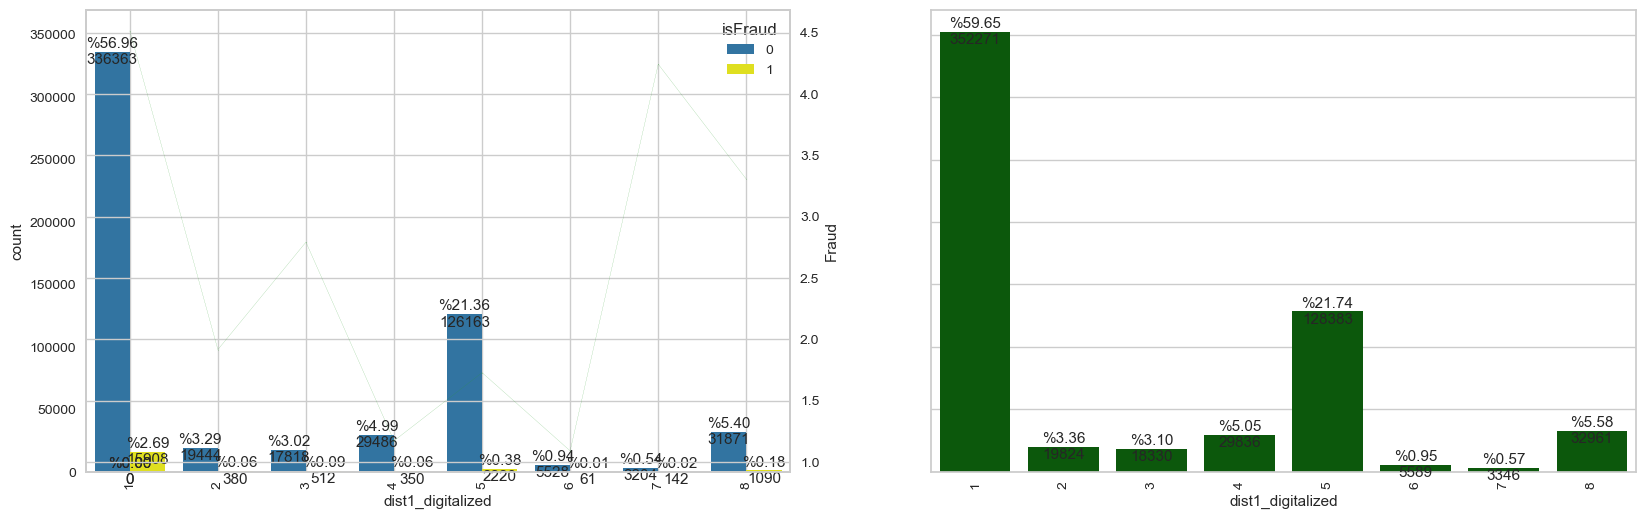

In [69]:
train1['dist1_digitalized'] = pd.Series(
    np.digitize(train1['dist1'].fillna(-1), bins=[-1, 0, 1, 2, 4, 50, 75, 100, 10300])
)

plot_col('dist1_digitalized', df=train1)

In [70]:
train1['dist1'] = train1['dist1'].fillna(999)

Cette variable présente énormement de valeurs manquantes. Ces dernières peuvent être informatives Pour éviter les biais, nous les gardons et leur assignons une valeur significative '999'

### TransactionDT

In [71]:
train1['TransactionDT'].describe()

count    5.905400e+05
mean     7.372311e+06
std      4.617224e+06
min      8.640000e+04
25%      3.027058e+06
50%      7.306528e+06
75%      1.124662e+07
max      1.581113e+07
Name: TransactionDT, dtype: float64

In [72]:
desc_col(expr=r'TransactionDT', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

TransactionDT: int32, 573349 valeurs uniques, 0.0% de valeurs manquantes
Valeurs uniques : [   86400    86401    86469 ... 15811079 15811088 15811131]



Cette variable ne contient pas de valeurs manquantes. Nous commençons à y extraires des features.

Nous extrayons ici des features temporelles relatives à partir de la variable TransactionDT, qui représente le temps écoulé depuis un point de départ inconnu. Ces variables permettront d’analyser le comportement des transactions dans le temps, sans dépendre d’une date réelle.
Transaction_day : identifiant du jour relatif de la transaction (jour 0, jour 1, ...).

Transaction_hour : heure relative de la journée (0 à 23) pour observer les comportements horaires.

Transaction_days_since_start : temps écoulé depuis le début du dataset, en jours décimaux.

txn_per_day : nombre total de transactions enregistrées chaque jour.

delta_card1 : temps écoulé depuis la dernière transaction du même utilisateur (card1)

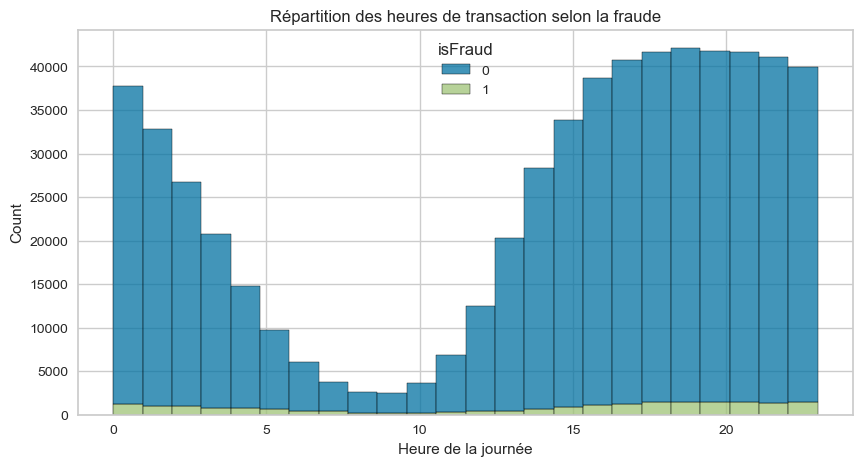

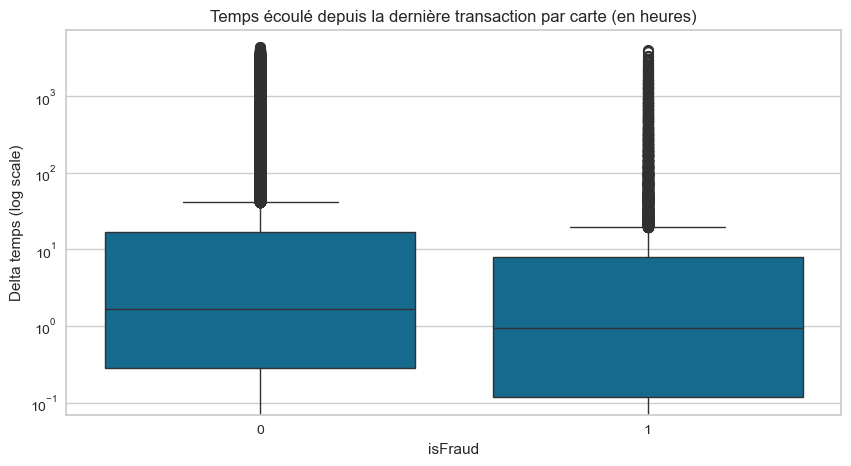

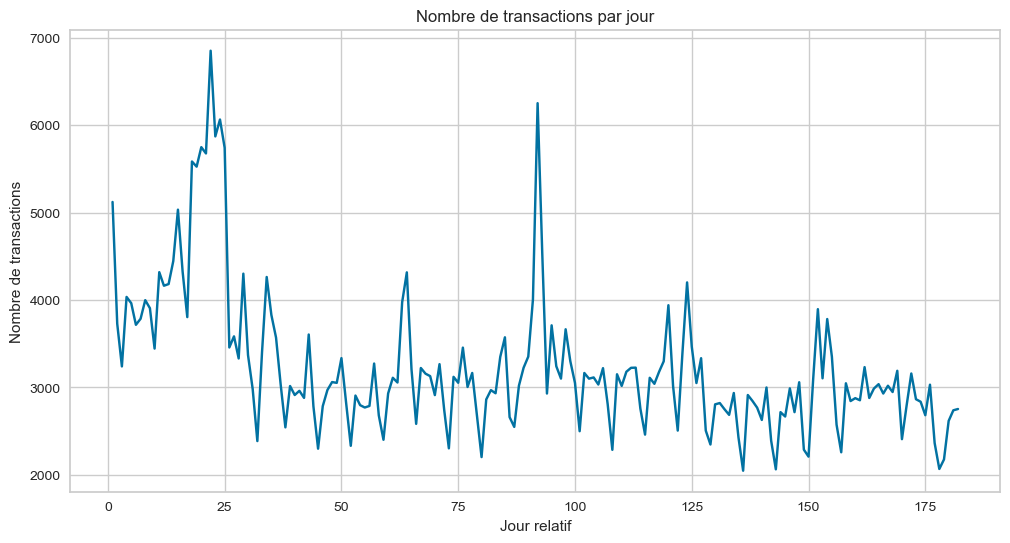

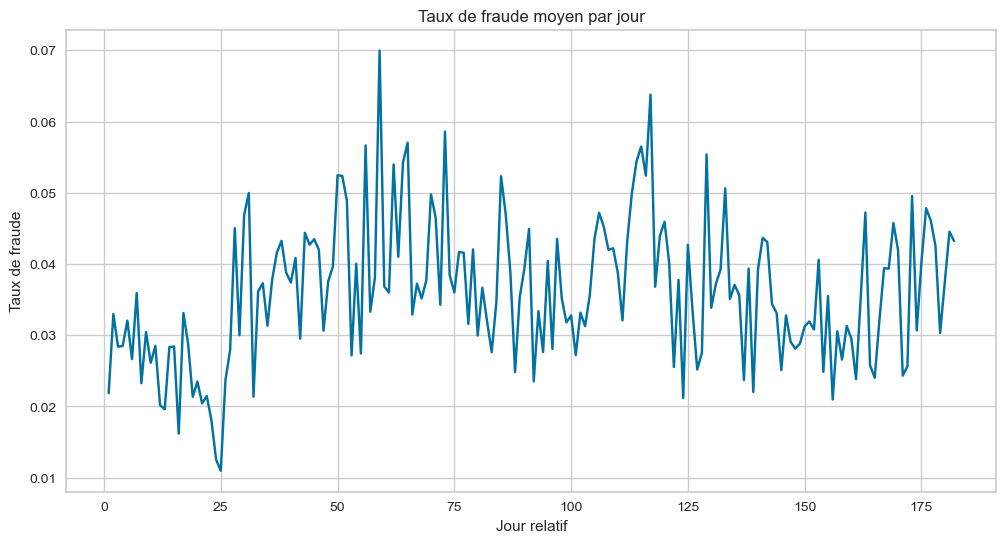

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que 'train' est ton DataFrame principal avec 'TransactionDT', 'TransactionID', 'card1' et 'isFraud'

# 1. Création des variables temporelles
train1['Transaction_day'] = train1['TransactionDT'] // 86400
train1['Transaction_hour'] = (train1['TransactionDT'] % 86400) // 3600
train1['Transaction_days_since_start'] = train1['TransactionDT'] / 86400

# 2. Nombre de transactions par jour
txn_per_day = train1.groupby('Transaction_day')['TransactionID'].count().rename('txn_per_day')

# Correction : réinitialisation de l’index pour permettre un merge propre
txn_per_day = txn_per_day.reset_index()

# Forcer les deux types pour éviter toute erreur de type
txn_per_day['Transaction_day'] = txn_per_day['Transaction_day'].astype('int64')
train1['Transaction_day'] = train1['Transaction_day'].astype('int64')

# Fusion propre
train1 = train1.merge(txn_per_day, on='Transaction_day', how='left')


# 3. Délai depuis la dernière transaction par carte
train1 = train1.sort_values(['card1', 'TransactionDT'])
train1['delta_card1'] = train1.groupby('card1', observed=False)['TransactionDT'].diff() / 3600

# Visualisations

# A. Distribution des heures des transactions selon fraude ou non
plt.figure(figsize=(10, 5))
sns.histplot(data=train1, x='Transaction_hour', hue='isFraud', multiple='stack', bins=24)
plt.title('Répartition des heures de transaction selon la fraude')
plt.xlabel('Heure de la journée')
plt.show()

# B. Temps écoulé depuis dernière transaction par carte selon fraude ou non
plt.figure(figsize=(10, 5))
sns.boxplot(data=train1[train1['delta_card1'] >= 0], x='isFraud', y='delta_card1')
plt.yscale('log')
plt.title('Temps écoulé depuis la dernière transaction par carte (en heures)')
plt.ylabel('Delta temps (log scale)')
plt.show()

# C. Nombre de transactions par jour
plt.figure(figsize=(12, 6))
sns.lineplot(data=train1.groupby('Transaction_day').agg({'isFraud':'mean', 'TransactionID':'count'}).reset_index(),
             x='Transaction_day', y='TransactionID')
plt.title('Nombre de transactions par jour')
plt.xlabel('Jour relatif')
plt.ylabel('Nombre de transactions')
plt.show()

# D. Taux de fraude moyen par jour
plt.figure(figsize=(12, 6))
daily_fraud_rate = train1.groupby('Transaction_day')['isFraud'].mean().reset_index()
sns.lineplot(data=daily_fraud_rate, x='Transaction_day', y='isFraud')
plt.title('Taux de fraude moyen par jour')
plt.xlabel('Jour relatif')
plt.ylabel('Taux de fraude')
plt.show()


### TransactionAmt

In [74]:
desc_col(expr=r'TransactionAmt', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

TransactionAmt: float16, 8195 valeurs uniques, 0.0% de valeurs manquantes
Valeurs uniques : [2.510e-01 2.720e-01 2.920e-01 ... 6.084e+03 6.452e+03 3.194e+04]



In [75]:
train1['TransactionAmt'] = train1['TransactionAmt'].astype('float32')
print(train1['TransactionAmt'].dtype)  # vérifier le type
print(train1['TransactionAmt'].describe())  # résumé statistique
print(train1[train1['TransactionAmt'] < 0])  # vérifier valeurs négatives (anomalies)
print(train1[train1['TransactionAmt'].isna()])  # vérifier valeurs manquantes


float32
count    590540.000000
mean        135.027344
std         239.186005
min           0.250977
25%          43.312500
50%          68.750000
75%         125.000000
max       31936.000000
Name: TransactionAmt, dtype: float64
Empty DataFrame
Columns: [TransactionID, isFraud, TransactionDT, TransactionAmt, ProductCD, card1, card2, card3, card4, card5, card6, addr1, addr2, dist1, P_emaildomain, R_emaildomain, C1, C2, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, D1, D2, D3, D4, D5, D10, D11, D15, M1, M2, M3, M4, M5, M6, M7, M8, M9, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V30, V31, V32, V33, V34, V35, V36, V37, V38, V39, V40, V41, V42, V43, V44, V45, V46, V47, V48, V49, V50, V51, V52, V53, V54, ...]
Index: []
Empty DataFrame
Columns: [TransactionID, isFraud, TransactionDT, TransactionAmt, ProductCD, card1, card2, card3, card4, card5, card6, addr1, addr2, dist1, P_emaildomain, R_emaildomai

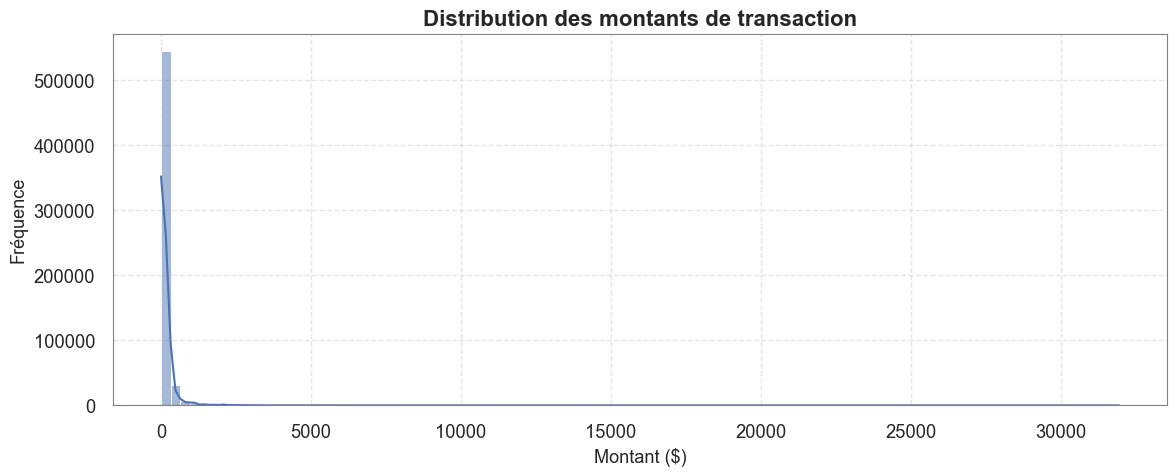

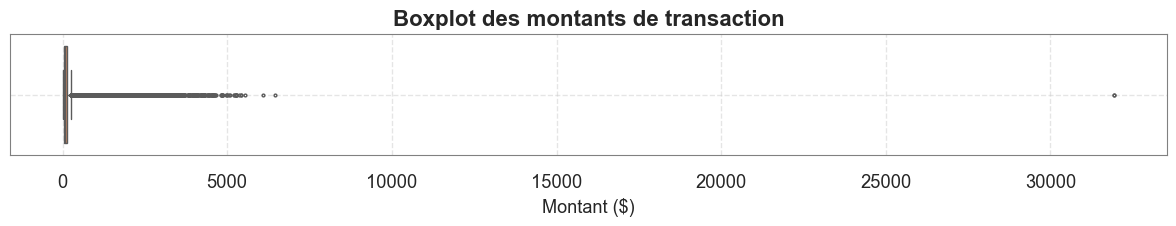

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Appliquer un style clair 
sns.set(style="whitegrid", palette="deep", font="Arial", font_scale=1.2)
plt.rcParams['axes.edgecolor'] = 'gray'
plt.rcParams['axes.linewidth'] = 0.8

# Supprimer les valeurs manquantes
df = train1[train1['TransactionAmt'].notna()]

# Histogramme avec KDE
plt.figure(figsize=(12, 5))
sns.histplot(df['TransactionAmt'], bins=100, kde=True, color="#4C72B0", edgecolor="white")
plt.title('Distribution des montants de transaction', fontsize=16, weight='bold')
plt.xlabel('Montant ($)', fontsize=13)
plt.ylabel('Fréquence', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(12, 2.5))
sns.boxplot(x=df['TransactionAmt'], color="#DD8452", fliersize=2)
plt.title('Boxplot des montants de transaction', fontsize=16, weight='bold')
plt.xlabel('Montant ($)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Cette variable est très asymétriques et présente énormememnt de valeurs abberrantes concentrées dans les montants inférieurs à 5000 ; à partir de 5000 les valeurs sont très dispersées étant donnée que certaines de ces valeurs peuvent être des signes de fraude 

### Variables D1-15

In [77]:
desc_col(expr=r'^D\d.*', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

D1: float16, 641 valeurs uniques, 0.21% de valeurs manquantes
Valeurs uniques : [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 1

In [78]:
cols_D = [f'D{i}' for i in range(1, 16) if f'D{i}' in train1.columns]
train1[cols_D] = train1[cols_D].fillna(999)

### Variables V

In [79]:
# Traitement des variables V1 à V339
Vcols_init = ['V'+str(x) for x in range(1,340)]
Vcols = [col for col in Vcols_init if col in train1.columns]

print(f"Colonnes demandées : {len(Vcols_init)}")
print(f"Colonnes présentes dans train1 : {len(Vcols)}")

train1[Vcols].head()


Colonnes demandées : 339
Colonnes présentes dans train1 : 239


V1  V2  V3  V4  V5  V6  V7  V8  V9  V10  V11  V12  V13  V14  V15  V16  \
243924 NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  0.0  0.0  1.0  1.0  1.0   
182988 NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  0.0  0.0  1.0  0.0  0.0   
314550 NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  0.0  0.0  1.0  1.0  1.0   
341484 NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  0.0  0.0  1.0  1.0  1.0   
350343 NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  0.0  0.0  1.0  0.0  0.0   

        V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  \
243924  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
182988  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
314550  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
341484  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
350343  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   

        V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  \
243924  1.0  1.0  1.0  1.0  0.0  0.0  1.0  2.0  1.0  1.0  1.0  1.0  2.0  1.0   
182988  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
314550  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
341484  1.0  1.0  1.0  1.0  0.0  0.0  1.0  2.0  1.0  1.0  1.0  1.0  2.0  1.0   
350343  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

        V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  \
243924  2.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
182988  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0   
314550  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
341484  1.0  1.0  2.0  0.0  0.0  1.0  1.0  2.0  0.0  0.0  1.0  2.0  1.0  1.0   
350343  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0  2.0  1.0  1.0   

        V59  V60  V61  V62  V63  V64  V65  V66  V67  V68  V69  V70  V71  V72  \
243924  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0   
182988  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0   
314550  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0   
341484  1.0  1.0  1.0  1.0  1.0  2.0  1.0  1.0  2.0  0.0  0.0  0.0  1.0  1.0   
350343  1.0  1.0  1.0  1.0  1.0  2.0  1.0  1.0  2.0  0.0  0.0  0.0  1.0  1.0   

        V73  V74  V75  V76  V77  V78  V79  V80  V81  V82  V83  V84  V85  V86  \
243924  1.0  1.0  0.0  0.0  1.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0  2.0  1.0   
182988  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
314550  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
341484  1.0  2.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
350343  1.0  2.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

        V87  V88  V89  V90  V91  V92  V93  V94  V95  V96  V97  V99  V100  \
243924  2.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   0.0   
182988  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   
314550  1.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   0.0   
341484  1.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   0.0   
350343  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  0.0  0.0   0.0   

        V126  V127  V128  V130  V131  V167  V168  V169  V170  V171  V172  \
243924   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   1.0   2.0   0.0   
182988   0.0   0.0   0.0   0.0   0.0   NaN   NaN   NaN   NaN   NaN   NaN   
314550   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0   
341484   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   1.0   2.0   0.0   
350343   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   1.0   2.0   0.0   

        V173  V174  V175  V176  V177  V178  V179  V180  V181  V182  V183  \
243924   0.0   1.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
182988   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

On peut remarquer à partir du heatmap que certaines de ces variables sont constituées en groupes de variables très correlées.Nous avons un premier groupe de V1 à V96 environ et un second comprenant le reste. Ces variables peuvent créer des redondances, il est donc essentiel de réduire leur dimensionnalité.

In [80]:
missing_percent = 100 * train1[Vcols].isna().sum() / train1.shape[0]
missing_percent_sorted = missing_percent[missing_percent > 0].sort_values(ascending=False)
print(missing_percent_sorted)

V224    77.913435
V253    77.913435
V249    77.913435
V248    77.913435
V247    77.913435
          ...    
V287     0.002032
V285     0.002032
V280     0.002032
V279     0.002032
V317     0.002032
Length: 239, dtype: float64


Le pourcentage de valeurs manquantes atteint 86,12 % pour certaines variables. Remarquons que certaines variables ont le même % de NA. Nous allons les regrouper pour les étudier en profondeur.

In [81]:
nan_df = train.isna()
nan_groups = {} # dictionary containing colunms with the same sum of nan
for c in Vcols:
    # sum of nan of each columns
    col_sum = nan_df[c].sum()
    if col_sum in nan_groups.keys():
        nan_groups[col_sum].append(c)
    else:
        nan_groups[col_sum] = [c]
del nan_df
print('Il y a ' + str(len(list(nan_groups.keys())))+ ' groupes de variables V contenant le même nombre de valeurs manquantes.')

Il y a 12 groupes de variables V contenant le même nombre de valeurs manquantes.


In [82]:
for key,value in nan_groups.items():
    print('NAN count',key)
    print(value)

NAN count 279287
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11']
NAN count 76073
['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34']
NAN count 168969
['V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52']
NAN count 77096
['V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74']
NAN count 89164
['V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94']
NAN count 314
['V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131']
NAN count 450909
['V167', 'V168', 'V172', 'V173', 'V176', 'V177', 'V178', 'V179', 'V181', 'V182', 'V183', 'V186', 'V187', 'V190', 'V191', 'V192', 'V193', 'V196', 'V199', 'V2


Groupe 1 : 11 colonnes avec 279287 valeurs manquantes chacune


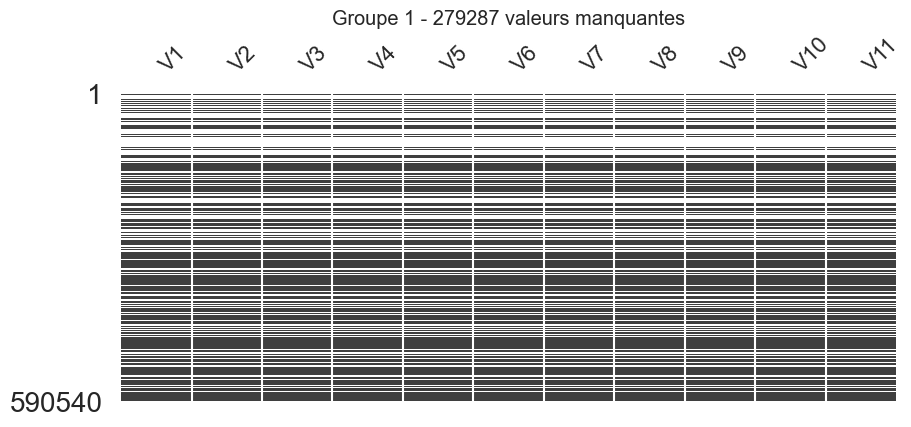


Groupe 2 : 23 colonnes avec 76073 valeurs manquantes chacune


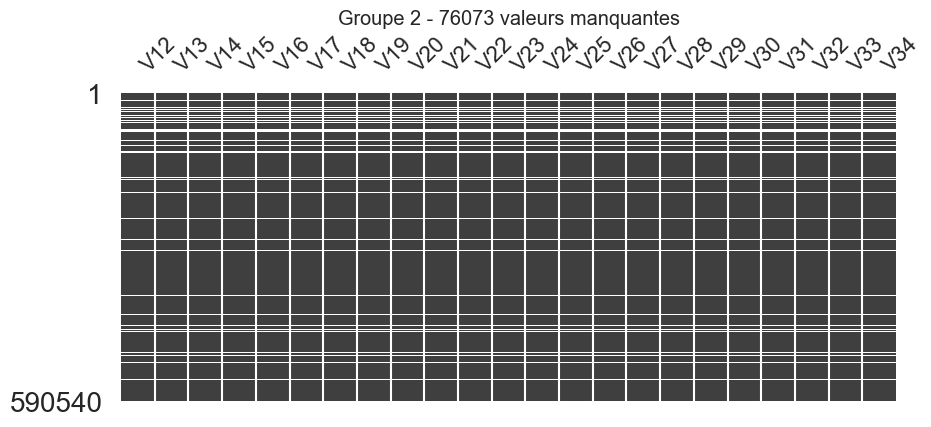


Groupe 3 : 18 colonnes avec 168969 valeurs manquantes chacune


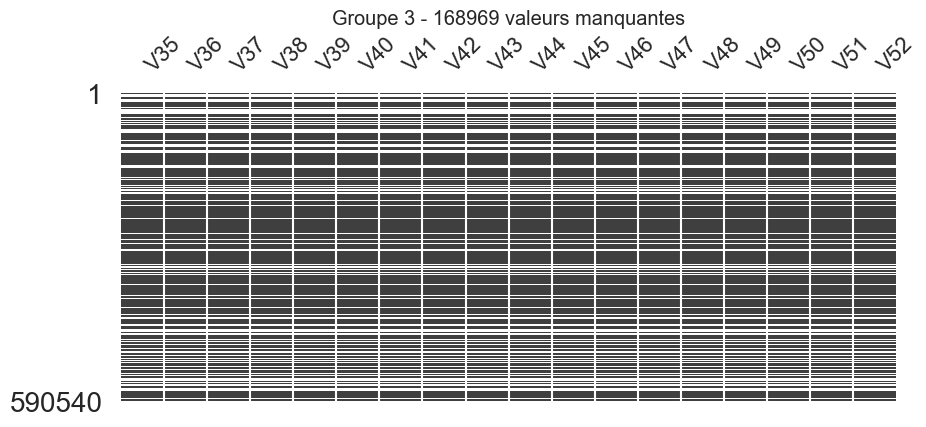


Groupe 4 : 22 colonnes avec 77096 valeurs manquantes chacune


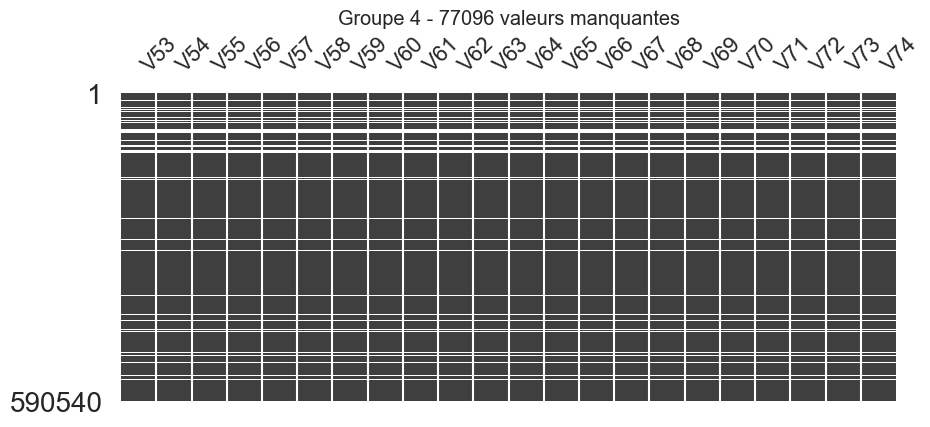


Groupe 5 : 20 colonnes avec 89164 valeurs manquantes chacune


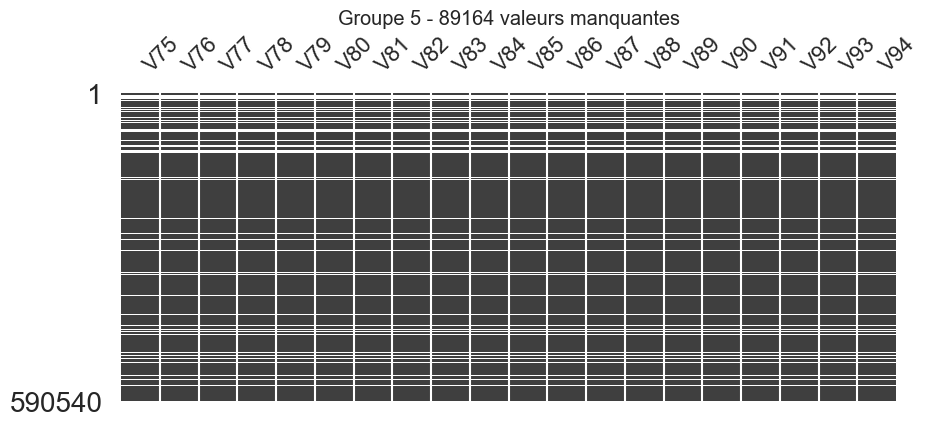


Groupe 6 : 10 colonnes avec 314 valeurs manquantes chacune


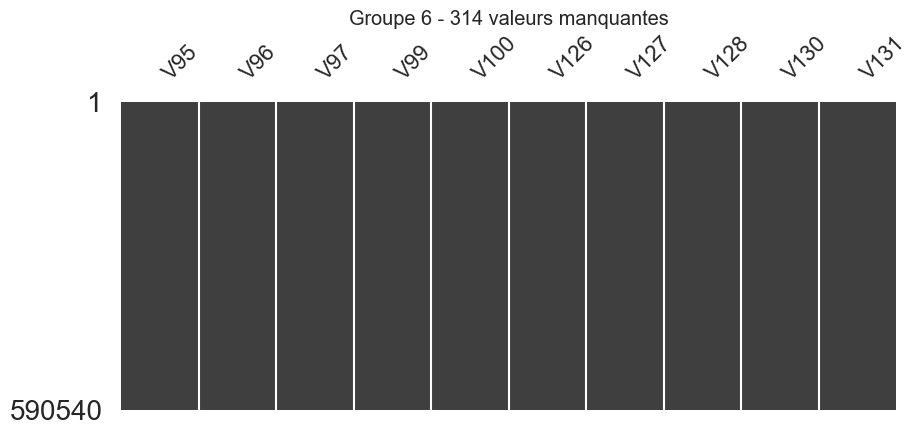


Groupe 7 : 31 colonnes avec 450909 valeurs manquantes chacune


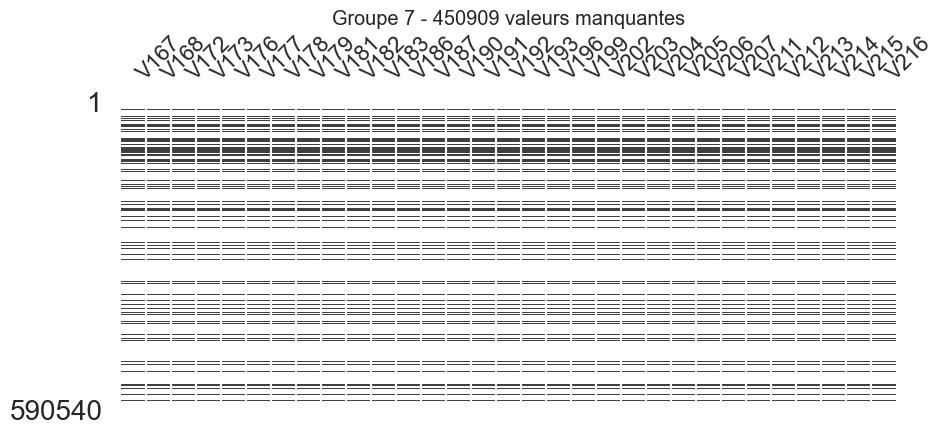


Groupe 8 : 19 colonnes avec 450721 valeurs manquantes chacune


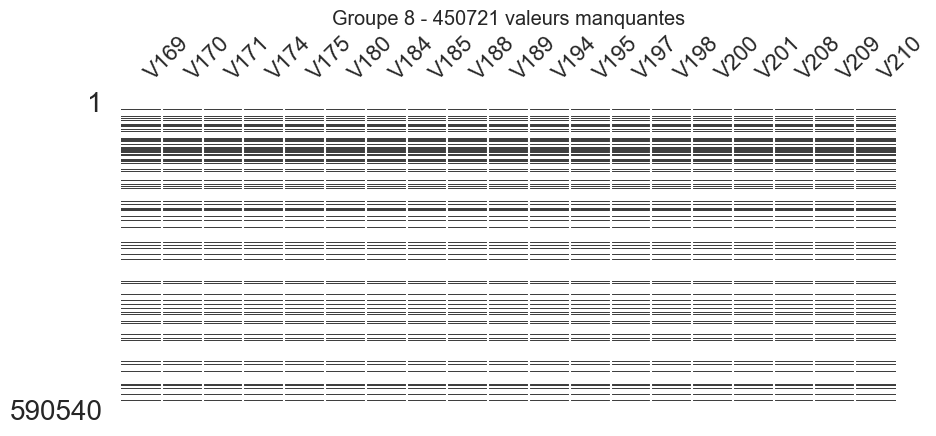


Groupe 9 : 46 colonnes avec 460110 valeurs manquantes chacune


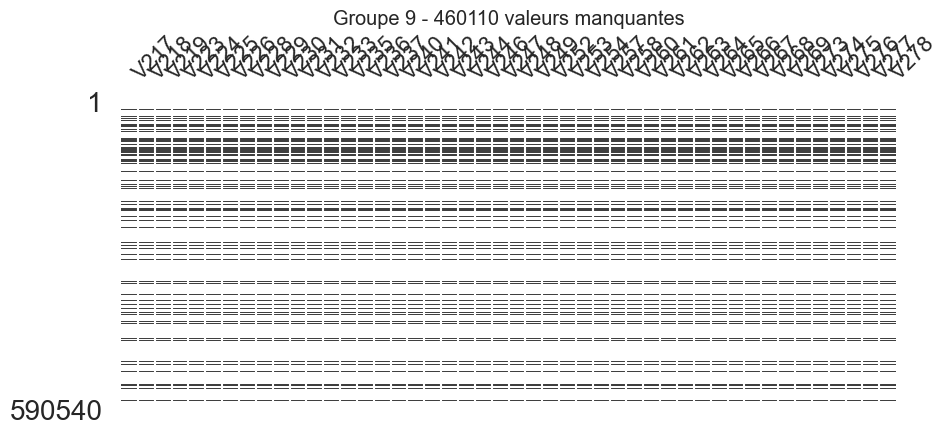


Groupe 10 : 16 colonnes avec 449124 valeurs manquantes chacune


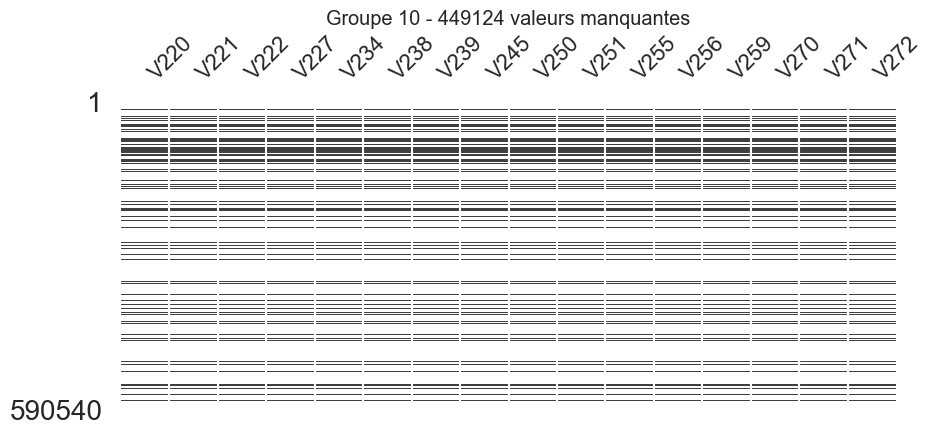


Groupe 11 : 16 colonnes avec 12 valeurs manquantes chacune


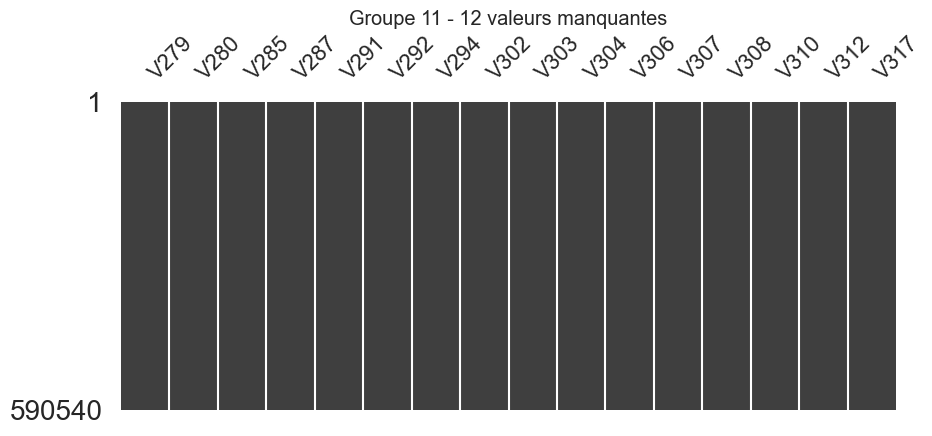


Groupe 12 : 7 colonnes avec 1269 valeurs manquantes chacune


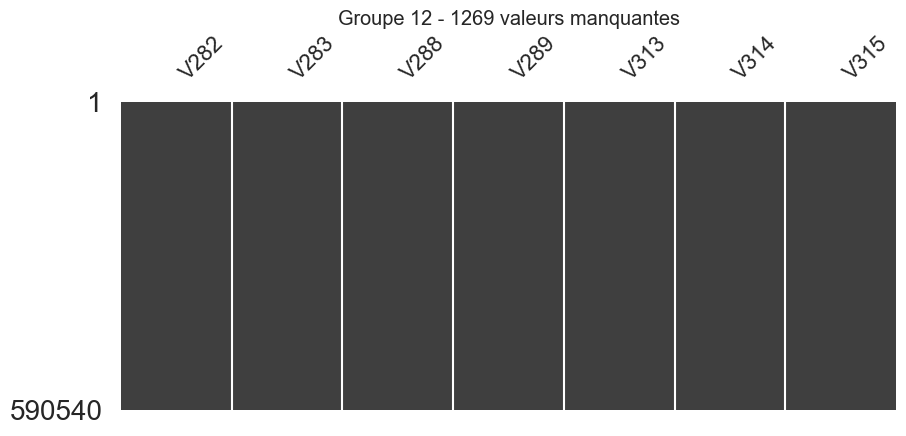

In [83]:
import missingno as msno
import matplotlib.pyplot as plt

# Afficher les graphiques msno.matrix() pour chaque groupe de colonnes
for i, (nan_count, cols) in enumerate(nan_groups.items(), 1):
    if len(cols) < 2:
        continue  # pas la peine d'afficher un graphique pour une seule colonne

    print(f"\nGroupe {i} : {len(cols)} colonnes avec {nan_count} valeurs manquantes chacune")
    msno.matrix(train[cols], sparkline=False, figsize=(10, 4))
    plt.title(f'Groupe {i} - {nan_count} valeurs manquantes')
    plt.show()


Les différents groupes ont non seulement les même pourcentages de valeurs manquantes mais également ces dernières concernent les mêmes lignes.

<Axes: >

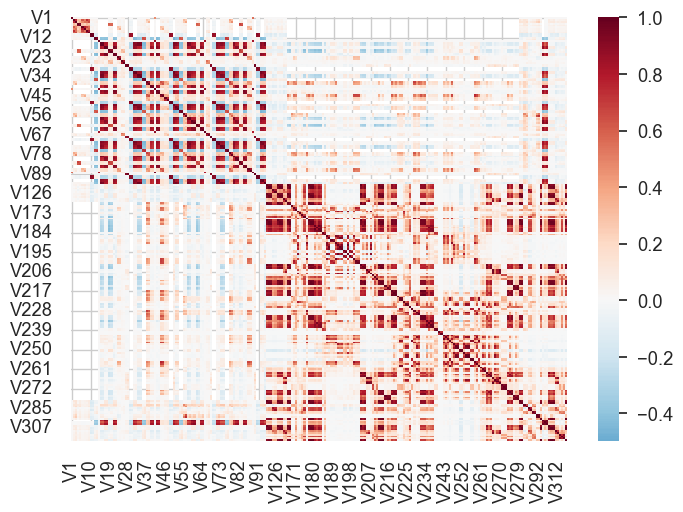

In [84]:
sns.heatmap(train1[Vcols].corr(),cmap = 'RdBu_r',annot=False,center=0.0)

Ces variables semblent correlées. Il faudra supprimer certaines de ces variables pour éviter une multicolinéarité. 

In [85]:
desc_col(expr='V', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

V1: float16, 2 valeurs uniques, 47.29% de valeurs manquantes
Valeurs uniques : [ 0.  1. nan]

V2: float16, 9 valeurs uniques, 47.29% de valeurs manquantes
Valeurs uniques : [ 0.  1.  2.  3.  4.  5.  6.  7.  8. nan]

V3: float16, 10 valeurs uniques, 47.29% de valeurs manquantes
Valeurs uniques : [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. nan]

V4: float16, 7 valeurs uniques, 47.29% de valeurs manquantes
Valeurs uniques : [ 0.  1.  2.  3.  4.  5.  6. nan]

V5: float16, 7 valeurs uniques, 47.29% de valeurs manquantes
Valeurs uniques : [ 0.  1.  2.  3.  4.  5.  6. nan]

V6: float16, 10 valeurs uniques, 47.29% de valeurs manquantes
Valeurs uniques : [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. nan]

V7: float16, 10 valeurs uniques, 47.29% de valeurs manquantes
Valeurs uniques : [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. nan]

V8: float16, 9 valeurs uniques, 47.29% de valeurs manquantes
Valeurs uniques : [ 0.

In [86]:
train1[Vcols] = train[Vcols].fillna(-1)

### Vérifications dans la base et importation

In [87]:
missing_counts = train1.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
print(missing_counts)

DeviceInfo       471874
R_emaildomain    453249
DeviceType       449730
P_emaildomain     94456
delta_card1       13553
dtype: int64


Après traitement global de la base, DeviceInfo, R_emaildomain, DeviceType, P_emaildomain  présentent toujours des valeurs manquantes. Nous avons choisi de ne pas les traiter car elles ne serviront pas directement dans la prédiction. En effet à partir de ces variables, de nouvelles variables ont été crées en prenant en compte leurs valeurs manquantes. Ces dernières ont ensuite été traitées.

In [88]:
#train1.to_csv("train4.csv", index=False)

##### Conclusion de l'EDA-1
Dans le cadre de cette première préparation des données, plusieurs étapes ont été réalisées afin d'améliorer la qualité des variables et de les rendre exploitables pour la modélisation. Les valeurs manquantes ont été traitées de manière adaptée selon le type de variable : par le mode ou par une étiquette explicite ('undefined','uunknown') pour les variables catégorielles ou par le mode / valeur spécifique ('999','-1') pour les variables numériques. Certaines variables ont été transformées (ex. emaildomain, addr1, addr2) afin d’en extraire des composantes plus informatives.
La description et la vraie nature des variables n’étant pas toujours, et dans un contexte de détection de fraude, les valeurs extrêmes peuvant justement contenir des signaux clés, nous avons choisi de préserver les valeurs abberantes. L’objectif a été de préserver au maximum l’information brute tout en rendant les données exploitables par les algorithmes.
Un deuxième traitement consistera à ameliorer cette exploitabilité. 